<a href="https://colab.research.google.com/github/aren4/Liver_Tumors/blob/main/Tommy_Rads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit_survival

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.3/298.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.3 MB/s eta 0:00:00
  Attempting uninstall: osqp
    Found existing installation: osqp 1.0.4
    Uninstalling osqp-1.0.4:
      Successfully uninstalled osqp-1.0.4


In [2]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 6.6 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=020a34088eedd96a93af4b9e376e7fb8a060520aac866e35a061b8bb8ae72864
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.linear_model import CoxPHSurvivalAnalysis
from lifelines import CoxPHFitter, KaplanMeierFitter
from sksurv.nonparametric import kaplan_meier_estimator
from tqdm import tqdm
import re

pd.set_option('display.max_columns', None)

df = pd.read_csv('/content/drive/MyDrive/Tommy Rads/Secondary Analysis.csv', index_col=False, encoding='latin1')

In [4]:
numeric_cols = df.select_dtypes(include=np.number).columns

# Apply the mask to only the numeric columns
df[numeric_cols] = df[numeric_cols].mask(df[numeric_cols] < 0)

print(df)

    Date Ablation  Last Name        ID # First Name        DOB Sex   Race  \
0      12/22/2022     HORNER  8471498543       JOSH  9/26/1972   M  White   
1      12/19/2022     TAYLOR  8474225240     DONALD  9/22/1949   M  Black   
2       9/28/2022  DOUGHERTY  8443623400     ANDREA  3/20/1981   F  White   
3        8/3/2022       TORO  8464386796      CAROL  8/12/1959   F  White   
4       7/19/2022     KOFFEL  1002771556    MICHELE  9/20/1983   F  White   
..            ...        ...         ...        ...        ...  ..    ...   
132     4/16/2015    ANSELMO   441880150     JOSEPH  7/26/1945   M  White   
133     2/17/2015     RUDMAN   442666962  CATHERINE   3/9/1964   F  White   
134     2/12/2015    MCMAHON   443552039    MICHAEL  3/21/1966   M  White   
135     1/28/2015  WILKINSON    59872176      DEBRA  12/2/1963   F  White   
136      1/6/2015      EWING     6698286       ANNE   2/8/1938   F  White   

       Ethnicity  type of cancer Date Dx Different Primary  \
0    NotHispa

In [5]:
# Replace '-' with NaN
df.replace('-', np.nan, inplace=True)

# Helper function to flag unexpected values
def flag_unexpected(series, expected_type, allowed_values=None, pattern=None):
    flagged = []
    for idx, val in series.items():
        if pd.isna(val):
            continue
        if allowed_values is not None and val not in allowed_values:
            flagged.append((idx, val))
        elif expected_type == 'numeric':
            try:
                float(str(val).replace('A','')) # '12A' becomes '12'
            except:
                flagged.append((idx, val))
        elif expected_type == 'binary':
            if str(val) not in ['0', '1']:
                flagged.append((idx, val))
        elif pattern is not None:
            if not re.match(pattern, str(val)):
                flagged.append((idx, val))
    return flagged

# Cleaning report dictionary
cleaning_report = {}

# Sex: Recode to binary Sex: Male
df['Sex'] = df['Sex'].str.strip().str.upper().replace({'MALE': 'M', 'FEMALE': 'F'})
sex_binary = df['Sex'].map({'M': 1, 'F': 0})
df['Sex: Male'] = sex_binary
cleaning_report['Sex'] = flag_unexpected(df['Sex'], 'str', allowed_values=['M', 'F'])

# Race
allowed_races = ['White', 'Black', 'Asian', 'Other', 'Unknown']
df['Race'] = df['Race'].astype(str).str.strip().str.title()
cleaning_report['Race'] = flag_unexpected(df['Race'], 'str', allowed_values=allowed_races)

# Ethnicity
allowed_ethnicities = ['Hispanic', 'Nothispanic', 'Unknown']
df['Ethnicity'] = df['Ethnicity'].astype(str).str.strip().str.title()
cleaning_report['Ethnicity'] = flag_unexpected(df['Ethnicity'], 'str', allowed_values=allowed_ethnicities)

# Type of cancer
df['type of cancer'] = df['type of cancer'].astype(str).str.strip().str.lower()

# Age
df['Age Date Dx Liver Cancer'] = pd.to_numeric(df['Age Date Dx Liver Cancer'], errors='coerce')
cleaning_report['Age Date Dx Liver Cancer'] = flag_unexpected(df['Age Date Dx Liver Cancer'], 'numeric')

# CAT HCV
allowed_hcv = [0, 2]
df['CAT HCV (2SVR, 1 for chronic/present, 3 HBV 4 HAV)'] = pd.to_numeric(
    df['CAT HCV (2SVR, 1 for chronic/present, 3 HBV 4 HAV)'], errors='coerce'
)
cleaning_report['CAT HCV'] = flag_unexpected(
    df['CAT HCV (2SVR, 1 for chronic/present, 3 HBV 4 HAV)'], 'numeric', allowed_values=allowed_hcv)

# Define a mapping of scores to integers
score_mapping = {
    '5': 1,
    '6': 2,
    '7': 3,
    '8': 4,
    '9': 5,
    '10': 6,
    '11': 7,
    '12': 8,
    '13': 9,
    '14': 10,
    '15': 11
}

# Function to extract the relevant score from the string, while handling NaN values
def extract_score(text):
    if isinstance(text, str):  # Check if the entry is a string
        for score in score_mapping:
            if re.search(score, text):
                return score
    return None  # Return None if NaN or no match is found

# Apply the function to extract the score and then map it to the integer value
df['SCALAR CPT Score (Extracted)'] = df['CPT Score'].apply(extract_score)
df['SCALAR CPT Score (Recode)'] = df['SCALAR CPT Score (Extracted)'].map(score_mapping)

# Binary columns
binary_cols = ['EtOH', 'NASH', 'Ascites', 'Encephalopathy', 'First CEA Elevated',
               'Unilobar (0), Bilobar (1)', 'Bx during ablation (0no, 1yes, 2NGS)']
for col in binary_cols:
    allowed = ['0', '1'] if 'Bx during ablation' not in col else ['0', '1', '2']
    df[col] = df[col].astype(str).str.strip()
    df[col].replace('', np.nan, inplace=True)
    cleaning_report[col] = flag_unexpected(df[col], 'binary', allowed_values=allowed)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Scalar numeric columns
scalar_cols = ['WBC', 'Hgb', 'Plt', 'Na', 'Cr', 'Albumin', 'Tbili', 'INR', 'CEA',
               '#tumors to ablate', 'Longest Diameter Largest lesion (mm)',
               'Sum Longest Diameters', 'PS', 'Time to recur', 'SCALAR CPT Score (Recode)', 'First ablation total energy']
for col in scalar_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    cleaning_report[col] = flag_unexpected(df[col], 'numeric')

# Segment Largest Index Lesion (integer, sometimes with an 'A' suffix)
def clean_segment(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, str) and x.endswith('A'):
        x = x[:-1]
    try:
        return int(x)
    except:
        return np.nan
df['Segment Largest Index Lesion'] = df['Segment Largest Index Lesion'].apply(clean_segment)
cleaning_report['Segment Largest Index Lesion'] = flag_unexpected(df['Segment Largest Index Lesion'], 'numeric')


/tmp/ipython-input-5-253865620.py:92: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace('', np.nan, inplace=True)
/tmp/ipython-input-5-253865620.py:92: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

In [6]:
df.head()

,Date Ablation,Last Name,ID #,First Name,DOB,Sex,Race,Ethnicity,type of cancer,Date Dx Different Primary,Date Dx Liver Cancer,Age Date Dx Liver Cancer,"CAT HCV (2SVR, 1 for chronic/present, 3 HBV 4 HAV)",EtOH,NASH,Ascites,Encephalopathy,WBC,Hgb,Plt,Na,Cr,Albumin,Tbili,INR,AFP,IU/ng,CEA,First CEA Elevated,#tumors to ablate,Longest Diameter Largest lesion (mm),Sum Longest Diameters,Segment Largest Index Lesion,"Unilobar (0), Bilobar (1)","Bx during ablation (0no, 1yes, 2NGS)",BCLC Stage,Native NaMELD,CPT Score,PS,"Liver Treatment prior to initial ablation (0none, 1TACE, 2TARE, 3EBRT, 4Systemic Therapy, 5resection, 6combined/other)",First ablation parameters,First ablation probe,First ablation total energy,Date PostAblation Imaging,"Recur (0no, 1yes)",Date of Imaging Recurrence,Time to recur,"Recurrence Local (0no, 1yes)",Recurrence EHD,Site of EHD,Description hepatic Recurrence,Size recurrent disease liver (mm),Treatment recurrence,Additional Details of Initial Repeat Tx/Rp Ablation parameters,Repeat ablation probe,Repeat ablation total energy,Ascites2,Encephalopathy2,WBC2,Hgb5,Plt6,Na7,Cr8,Albumin2,Tbili2,INR11,AFP12,AFP unit,CEA13,Second CEA Elevated,# tumors to ablate,Longest Diameter Largest lesion,Sum Longest Diameters15,Segment of Largest Index Lesion16,"Unilobar (0), Bilobar (1)17",BCLC,Native NaMELD18,CPT Score19,PS20,"Bx recurrence (0no,1yes,2NGS)",Date of Repeat Tx,Date Imaging after repeat treatment,Results followup Imaging at target lesion,Nontarget results,Date of first progression from Repeat,"Progression Local(0no,1yes)",TTP after repeat treatment,Date of last liver imaging,Response at last liver imaging,Nontarget response at last imaging,Date last follow up,Days between follow up and first ablation,"Status at last follow up (0alive, 1dead, 2LTFU)",Other notes,Time to recurrence post ablation,Sex: Male,SCALAR CPT Score (Extracted),SCALAR CPT Score (Recode)
0,12/22/2022,HORNER,8471498543,JOSH,9/26/1972,M,White,Nothispanic,colon,11/18/2021,11/2/2021,49,0,0,0,0,0,8.74,16.5,174.0,141.0,0.82,4.4,0.5,0.9,NaN,NaN,7.3,1.0,1,30,30,6.0,0,0,NaN,NaN,NaN,1.0,"4, 5",20cm Neuwave mp,PR20,650,1/18/2023,0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4/4/2023,CR,NaN,7/7/2023,197,0.0,"MWA was for recurrence, lung metastases but no...",44917,1,None,NaN
1,12/19/2022,TAYLOR,8474225240,DONALD,9/22/1949,M,Black,Unknown,colon,9/8/2021,10/26/2022,73,0,0,0,0,0,11.50,13.5,151.0,141.0,0.81,3.8,0.9,1.0,NaN,NaN,4.0,0.0,1,19,19,4.0,0,0,NaN,NaN,NaN,NaN,4,PR 65Wx10m,PR15,650,2/14/2023,0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2/14/2023,CR,NaN,7/17/2023,210,0.0,Only Continuity of Care notes available (VA). ...,44914,1,None,NaN
2,9/28/2022,DOUGHERTY,8443623400,ANDREA,3/20/1981,F,White,Nothispanic,leiomyosarcoma,11/13/2017,7/15/2022,41,0,0,0,0,0,3.80,13.0,211.0,136.0,0.94,4.6,0.7,1.0,NaN,NaN,2.4,NaN,1,22,22,2.0,1,1,NaN,NaN,NaN,0.0,"4,5",2 PR 65Wx5m,PR15,650,10/19/2022,1,10/21/2022,23.0,0.0,0.0,NaN,Enhancing diffusion restricting neoplasm in th...,12x9,0.0,Pr 65Wx5m,PR15,325.0,0.0,0.0,4.0,11.0,264.0,138.0,1.0,4.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,12.0,12.0,2,0.0,NaN,NaN,NaN,0.0,0.0,12/29/2022,1/31/2023,CR,PD,1/31/2023,0.0,0.0,8/28/2023,PD,PD,8/9/2023,315,1.0,"On lanreotide, DOTATATE, pazopanib",23,0,None,NaN
3,8/3/2022,TORO,8464386796,CAROL,8/12/1959,F,White,Nothispanic,lung,10/16/2018,1/6/2022,62,0,0,0,0,0,5.00,9.5,248.0,139.0,1.03,3.7,0.4,0.9,NaN,NaN,NaN,NaN,1,23,23,5.0,0,0,NaN,NaN,NaN,1.0,"6 (Bland embo), 4",15cm Neuwave mp,PR15,650,9/20/2022,1,9/20/2022,48.0,0.0,1.0,"Lung, Brain",postablation changes in the treated lesion. H...,Segment 7 (25/25) 1.5 x 1.5 cm. Inferior segme...,2.0,y90,NaN,NaN,0.0,0.0,10.0,10.0,136.0,139.0,1.0,4.0,0.0,1.0,NaN,NaN,NaN,NaN,3.0,16.0,44.0,7,1.0,NaN,NaN,NaN,1.0,0.0,11/16/2022,12/

In [7]:
# Liver Treatment prior to initial ablation
treatment_map = {
    '1': 'TACE',
    '2': 'TARE',
    '3': 'EBRT',
    '4': 'Systemic Therapy',
    '5': 'Resection',
    '6': 'Combined/Other'
}
def treatment_flags(cell):
    flags = {name: 0 for name in treatment_map.values()}
    if pd.isna(cell):
        return pd.Series(flags)
    items = re.findall(r'\d', str(cell))
    for item in items:
        if item in treatment_map:
            flags[treatment_map[item]] = 1
    return pd.Series(flags)
treatments = df['Liver Treatment prior to initial ablation (0none, 1TACE, 2TARE, 3EBRT, 4Systemic Therapy, 5resection, 6combined/other)'].apply(treatment_flags)
df = pd.concat([df, treatments], axis=1)
df.drop(columns=['Liver Treatment prior to initial ablation (0none, 1TACE, 2TARE, 3EBRT, 4Systemic Therapy, 5resection, 6combined/other)'], inplace=True)

# Recur (dependent)
df['Recur (0no, 1yes)'] = pd.to_numeric(df['Recur (0no, 1yes)'], errors='coerce')
cleaning_report['Recur (0no, 1yes)'] = flag_unexpected(df['Recur (0no, 1yes)'], 'binary', allowed_values=['0', '1'])

# Gather cleaning report and summarize any flagged values
flagged_summary = {col: flagged for col, flagged in cleaning_report.items() if flagged}
flagged_summary  # Show all columns with flagged/unexpected values and what those are


{'First CEA Elevated': [(0, '1.0'),
  (1, '0.0'),
  (2, 'nan'),
  (3, 'nan'),
  (4, 'nan'),
  (5, '0.0'),
  (6, '1.0'),
  (7, '1.0'),
  (8, '1.0'),
  (9, '0.0'),
  (10, 'nan'),
  (11, 'nan'),
  (12, '0.0'),
  (13, 'nan'),
  (14, '1.0'),
  (15, 'nan'),
  (16, '1.0'),
  (17, 'nan'),
  (18, 'nan'),
  (19, 'nan'),
  (20, '0.0'),
  (21, 'nan'),
  (22, 'nan'),
  (23, '0.0'),
  (24, 'nan'),
  (25, 'nan'),
  (26, '0.0'),
  (27, '0.0'),
  (28, '0.0'),
  (29, '1.0'),
  (30, '0.0'),
  (31, 'nan'),
  (32, 'nan'),
  (33, '1.0'),
  (34, '0.0'),
  (35, '1.0'),
  (36, 'nan'),
  (37, '0.0'),
  (38, '1.0'),
  (39, 'nan'),
  (40, 'nan'),
  (41, '1.0'),
  (42, 'nan'),
  (43, 'nan'),
  (44, 'nan'),
  (45, 'nan'),
  (46, 'nan'),
  (47, 'nan'),
  (48, '0.0'),
  (49, 'nan'),
  (50, 'nan'),
  (51, 'nan'),
  (52, 'nan'),
  (53, '1.0'),
  (54, '0.0'),
  (55, 'nan'),
  (56, 'nan'),
  (57, 'nan'),
  (58, '1.0'),
  (59, '1.0'),
  (60, 'nan'),
  (61, 'nan'),
  (62, 'nan'),
  (63, '1.0'),
  (64, 'nan'),
  (65, '1.0')

In [8]:
df.head()

,Date Ablation,Last Name,ID #,First Name,DOB,Sex,Race,Ethnicity,type of cancer,Date Dx Different Primary,Date Dx Liver Cancer,Age Date Dx Liver Cancer,"CAT HCV (2SVR, 1 for chronic/present, 3 HBV 4 HAV)",EtOH,NASH,Ascites,Encephalopathy,WBC,Hgb,Plt,Na,Cr,Albumin,Tbili,INR,AFP,IU/ng,CEA,First CEA Elevated,#tumors to ablate,Longest Diameter Largest lesion (mm),Sum Longest Diameters,Segment Largest Index Lesion,"Unilobar (0), Bilobar (1)","Bx during ablation (0no, 1yes, 2NGS)",BCLC Stage,Native NaMELD,CPT Score,PS,First ablation parameters,First ablation probe,First ablation total energy,Date PostAblation Imaging,"Recur (0no, 1yes)",Date of Imaging Recurrence,Time to recur,"Recurrence Local (0no, 1yes)",Recurrence EHD,Site of EHD,Description hepatic Recurrence,Size recurrent disease liver (mm),Treatment recurrence,Additional Details of Initial Repeat Tx/Rp Ablation parameters,Repeat ablation probe,Repeat ablation total energy,Ascites2,Encephalopathy2,WBC2,Hgb5,Plt6,Na7,Cr8,Albumin2,Tbili2,INR11,AFP12,AFP unit,CEA13,Second CEA Elevated,# tumors to ablate,Longest Diameter Largest lesion,Sum Longest Diameters15,Segment of Largest Index Lesion16,"Unilobar (0), Bilobar (1)17",BCLC,Native NaMELD18,CPT Score19,PS20,"Bx recurrence (0no,1yes,2NGS)",Date of Repeat Tx,Date Imaging after repeat treatment,Results followup Imaging at target lesion,Nontarget results,Date of first progression from Repeat,"Progression Local(0no,1yes)",TTP after repeat treatment,Date of last liver imaging,Response at last liver imaging,Nontarget response at last imaging,Date last follow up,Days between follow up and first ablation,"Status at last follow up (0alive, 1dead, 2LTFU)",Other notes,Time to recurrence post ablation,Sex: Male,SCALAR CPT Score (Extracted),SCALAR CPT Score (Recode),TACE,TARE,EBRT,Systemic Therapy,Resection,Combined/Other
0,12/22/2022,HORNER,8471498543,JOSH,9/26/1972,M,White,Nothispanic,colon,11/18/2021,11/2/2021,49,0,0,0,0,0,8.74,16.5,174.0,141.0,0.82,4.4,0.5,0.9,NaN,NaN,7.3,1.0,1,30,30,6.0,0,0,NaN,NaN,NaN,1.0,20cm Neuwave mp,PR20,650,1/18/2023,0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4/4/2023,CR,NaN,7/7/2023,197,0.0,"MWA was for recurrence, lung metastases but no...",44917,1,None,NaN,0,0,0,1,1,0
1,12/19/2022,TAYLOR,8474225240,DONALD,9/22/1949,M,Black,Unknown,colon,9/8/2021,10/26/2022,73,0,0,0,0,0,11.50,13.5,151.0,141.0,0.81,3.8,0.9,1.0,NaN,NaN,4.0,0.0,1,19,19,4.0,0,0,NaN,NaN,NaN,NaN,PR 65Wx10m,PR15,650,2/14/2023,0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2/14/2023,CR,NaN,7/17/2023,210,0.0,Only Continuity of Care notes available (VA). ...,44914,1,None,NaN,0,0,0,1,0,0
2,9/28/2022,DOUGHERTY,8443623400,ANDREA,3/20/1981,F,White,Nothispanic,leiomyosarcoma,11/13/2017,7/15/2022,41,0,0,0,0,0,3.80,13.0,211.0,136.0,0.94,4.6,0.7,1.0,NaN,NaN,2.4,NaN,1,22,22,2.0,1,1,NaN,NaN,NaN,0.0,2 PR 65Wx5m,PR15,650,10/19/2022,1,10/21/2022,23.0,0.0,0.0,NaN,Enhancing diffusion restricting neoplasm in th...,12x9,0.0,Pr 65Wx5m,PR15,325.0,0.0,0.0,4.0,11.0,264.0,138.0,1.0,4.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,12.0,12.0,2,0.0,NaN,NaN,NaN,0.0,0.0,12/29/2022,1/31/2023,CR,PD,1/31/2023,0.0,0.0,8/28/2023,PD,PD,8/9/2023,315,1.0,"On lanreotide, DOTATATE, pazopanib",23,0,None,NaN,0,0,0,1,1,0
3,8/3/2022,TORO,8464386796,CAROL,8/12/1959,F,White,Nothispanic,lung,10/16/2018,1/6/2022,62,0,0,0,0,0,5.00,9.5,248.0,139.0,1.03,3.7,0.4,0.9,NaN,NaN,NaN,NaN,1,23,23,5.0,0,0,NaN,NaN,NaN,1.0,15cm Neuwave mp,PR15,650,9/20/2022,1,9/20/2022,48.0,0.0,1.0,"Lung, Brain",postablation changes in the treated lesion. H...,Segment 7 (25/25) 1.5 x 1.5 cm. Inferior segme...,2.0,y90,NaN,NaN,0.0,0.0,10.0,10.0,136.0,139.0,1.0,4.0,0.0,1.0,NaN,NaN,NaN,NaN,3.0,16.0,44.0,7,1.0,NaN,NaN,NaN,1.0,0.0,11/16/2022,12/12/2022,PR,PD,12/12/2022,0.0,0.0,3/23/2023,SD,SD,3/21/2023,230,

In [9]:
# First CEA Elevated: Recode to binary integers
df['First CEA Elevated'] = df['First CEA Elevated'].replace({'1.0': 1, '0.0': 0}).astype(float)
# (Leave np.nan for missing)

# Bx during ablation: Create one-hot columns for Yes (1) and NGS (2)
df['Bx during ablation: Yes'] = (df['Bx during ablation (0no, 1yes, 2NGS)'] == 1).astype(int)
df['Bx during ablation: NGS'] = (df['Bx during ablation (0no, 1yes, 2NGS)'] == 2).astype(int)

df['First ablation probe: PR15'] = (df['First ablation probe'] == 'PR15').astype(int)
df['First ablation probe: PR15'] = (df['First ablation probe'] == 'PR').astype(int)
df['First ablation probe: PR20'] = (df['First ablation probe'] == 'PR20').astype(int)
df['First ablation probe: LK'] = (df['First ablation probe'] == 'LK').astype(int)
df['First ablation probe: Solaris'] = (df['First ablation probe'] == 'Solaris').astype(int)

# Show the first 10 rows of the cleaned dataframe for relevant columns
df[['First CEA Elevated', 'Bx during ablation (0no, 1yes, 2NGS)',
    'Bx during ablation: Yes', 'Bx during ablation: NGS', 'First ablation probe: PR15', 'First ablation probe: PR20', 'First ablation probe: LK', 'First ablation probe: Solaris']].head(10)


,First CEA Elevated,"Bx during ablation (0no, 1yes, 2NGS)",Bx during ablation: Yes,Bx during ablation: NGS,First ablation probe: PR15,First ablation probe: PR20,First ablation probe: LK,First ablation probe: Solaris
0,1.0,0,0,0,0,1,0,0
1,0.0,0,0,0,0,0,0,0
2,NaN,1,1,0,0,0,0,0
3,NaN,0,0,0,0,0,0,0
4,NaN,0,0,0,0,0,0,0
5,0.0,0,0,0,0,0,1,0
6,1.0,0,0,0,0,0,1,0
7,1.0,0,0,0,0,0,0,0
8,1.0,0,0,0,0,0,0,0
9,0.0,0,0,0,0,0,1,0


In [10]:
# Define columns
scalar_cols = [
    'Age Date Dx Liver Cancer', 'WBC', 'Hgb', 'Plt', 'Na', 'Cr', 'Albumin', 'Tbili', 'INR', 'First ablation total energy',
    'CEA', '#tumors to ablate', 'Longest Diameter Largest lesion (mm)', 'Sum Longest Diameters', 'PS', 'SCALAR CPT Score (Recode)'
]
binary_cols = [
    'Sex: Male', 'EtOH', 'NASH', 'Ascites', 'Encephalopathy', 'First CEA Elevated',
    'Unilobar (0), Bilobar (1)', 'Bx during ablation: Yes', 'Bx during ablation: NGS', 'First ablation probe: PR15',
    'First ablation probe: PR20', 'First ablation probe: LK', 'First ablation probe: Solaris', 'Recur (0no, 1yes)',
    'TACE',	'TARE',	'EBRT',	'Systemic Therapy',	'Resection',	'Combined/Other'
]
categorical_cols = [
    'Race', 'Ethnicity', 'type of cancer', 'CAT HCV (2SVR, 1 for chronic/present, 3 HBV 4 HAV)'
]

# Check scalar columns: should be numeric or NaN
scalar_issues = {}
for col in scalar_cols:
    not_scalar = df[~df[col].isna() & ~df[col].apply(lambda x: isinstance(x, (int, float)))][col]
    if not not_scalar.empty:
        scalar_issues[col] = not_scalar.unique().tolist()

# Check binary columns: should be 0, 1, or NaN
binary_issues = {}
for col in binary_cols:
    vals = set(df[col].dropna().unique())
    if not vals.issubset({0, 1}):
        binary_issues[col] = vals - {0, 1}

# Check categorical columns: show all unique values
categorical_uniques = {col: df[col].dropna().unique().tolist() for col in categorical_cols}

(scalar_issues, binary_issues, categorical_uniques)

df.to_csv("Secondary_Tumors_Cleaned.csv", index=False)
!cp Secondary_Tumors_Cleaned.csv "/content/drive/My Drive/Tommy Rads/"

In [11]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Exclude dependent variable from imputation
impute_cols = [col for col in (scalar_cols + binary_cols) if col != 'Recur (0no, 1yes)']

# Prepare input for imputation
impute_df = df[impute_cols]

# MICE imputation
mice = IterativeImputer(random_state=42, sample_posterior=True, max_iter=20)
imputed_array = mice.fit_transform(impute_df)
imputed_df = pd.DataFrame(imputed_array, columns=impute_cols, index=impute_df.index)

# Restore binary columns as integer 0/1
for col in binary_cols:
    if col in imputed_df.columns:
        imputed_df[col] = imputed_df[col].round().astype(int)

# Add back categorical and dependent columns, in original order
final_df = pd.concat(
    [imputed_df, df[categorical_cols + ['type of cancer', 'Recur (0no, 1yes)']]],
    axis=1
)

# Show head and check remaining NaNs
(final_df.head(), final_df.isna().sum())

(   Age Date Dx Liver Cancer    WBC   Hgb    Plt     Na    Cr  Albumin  Tbili  \
 0                      49.0   8.74  16.5  174.0  141.0  0.82      4.4    0.5   
 1                      73.0  11.50  13.5  151.0  141.0  0.81      3.8    0.9   
 2                      41.0   3.80  13.0  211.0  136.0  0.94      4.6    0.7   
 3                      62.0   5.00   9.5  248.0  139.0  1.03      3.7    0.4   
 4                      37.0   4.40  12.9  286.0  139.0  0.80      4.4    0.4   
 
    INR  First ablation total energy         CEA  #tumors to ablate  \
 0  0.9                        650.0    7.300000                1.0   
 1  1.0                        650.0    4.000000                1.0   
 2  1.0                        650.0    2.400000                1.0   
 3  0.9                        650.0  335.545819                1.0   
 4  1.1                       1300.0    0.000000                2.0   
 
    Longest Diameter Largest lesion (mm)  Sum Longest Diameters        PS  \
 0     

In [12]:
# Drop duplicate columns, if any (from prior concatenation)
final_df = final_df.loc[:,~final_df.columns.duplicated()]

# Define categorical columns
categorical_cols = ['Race', 'Ethnicity', 'type of cancer', 'CAT HCV (2SVR, 1 for chronic/present, 3 HBV 4 HAV)']

# One-hot encode, drop first to avoid collinearity
final_encoded = pd.get_dummies(final_df, columns=categorical_cols, drop_first=True)

# Show shape and column sample
(final_encoded.shape, final_encoded.columns.tolist()[:12])


((137, 56),
 ['Age Date Dx Liver Cancer',
  'WBC',
  'Hgb',
  'Plt',
  'Na',
  'Cr',
  'Albumin',
  'Tbili',
  'INR',
  'First ablation total energy',
  'CEA',
  '#tumors to ablate'])

In [13]:
final_encoded.head()

,Age Date Dx Liver Cancer,WBC,Hgb,Plt,Na,Cr,Albumin,Tbili,INR,First ablation total energy,CEA,#tumors to ablate,Longest Diameter Largest lesion (mm),Sum Longest Diameters,PS,SCALAR CPT Score (Recode),Sex: Male,EtOH,NASH,Ascites,Encephalopathy,First CEA Elevated,"Unilobar (0), Bilobar (1)",Bx during ablation: Yes,Bx during ablation: NGS,First ablation probe: PR15,First ablation probe: PR20,First ablation probe: LK,First ablation probe: Solaris,TACE,TARE,EBRT,Systemic Therapy,Resection,Combined/Other,"Recur (0no, 1yes)",Race_Black,Race_Other,Race_White,Ethnicity_Nothispanic,Ethnicity_Unknown,type of cancer_breast,type of cancer_colon,type of cancer_esophageal,type of cancer_gist,type of cancer_leiomyosarcoma,type of cancer_lung,type of cancer_net,type of cancer_ocular,type of cancer_ovarian,type of cancer_pancreas,type of cancer_parathyroid,type of cancer_parotid,type of cancer_renal,type of cancer_urothelial cc,"CAT HCV (2SVR, 1 for chronic/present, 3 HBV 4 HAV)_2"
0,49.0,8.74,16.5,174.0,141.0,0.82,4.4,0.5,0.9,650.0,7.300000,1.0,30.0,30.0,1.000000,1.879166,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,False,False,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
1,73.0,11.50,13.5,151.0,141.0,0.81,3.8,0.9,1.0,650.0,4.000000,1.0,19.0,19.0,0.145961,1.666242,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
2,41.0,3.80,13.0,211.0,136.0,0.94,4.6,0.7,1.0,650.0,2.400000,1.0,22.0,22.0,0.000000,2.428083,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,1,0,1,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
3,62.0,5.00,9.5,248.0,139.0,1.03,3.7,0.4,0.9,650.0,335.545819,1.0,23.0,23.0,1.000000,1.069249,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
4,37.0,4.40,12.9,286.0,139.0,0.80,4.4,0.4,1.1,1300.0,0.000000,2.0,17.0,32.0,0.000000,-0.003916,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False


In [14]:
# Build duration and event columns for Cox model
cox_df = final_encoded.copy()
# Use event: 1 if recurred, 0 if censored
cox_df['event'] = cox_df['Recur (0no, 1yes)']

# Duration: 'Time to recur' if event, else 'Days between follow up and first ablation'
# Ensure both are numeric
cox_df['Time to recur'] = pd.to_numeric(df['Time to recur'], errors='coerce')
cox_df['Days between follow up and first ablation'] = pd.to_numeric(df['Days between follow up and first ablation'], errors='coerce')

cox_df['duration'] = np.where(
    cox_df['event'] == 1,
    cox_df['Time to recur'],
    cox_df['Days between follow up and first ablation']
)

# Drop any rows missing duration or event
cox_df = cox_df.dropna(subset=['duration', 'event'])

# One-hot encode categorical variables (and treatment columns if not binary already)
categorical_cols = [
    'Race', 'Ethnicity', 'type of cancer', 'CAT HCV (2SVR, 1 for chronic/present, 3 HBV 4 HAV)',
    'TACE', 'TARE', 'EBRT', 'Systemic Therapy', 'Resection', 'Combined/Other'
]
# Only include those that exist (sometimes a treatment might not be present in this subset)
categorical_cols = [col for col in categorical_cols if col in cox_df.columns]

cox_encoded = pd.get_dummies(cox_df, columns=categorical_cols, drop_first=True)

# Drop extra time columns from predictors
for drop_col in ['Time to recur', 'Days between follow up and first ablation', 'Recur (0no, 1yes)']:
    if drop_col in cox_encoded.columns:
        cox_encoded = cox_encoded.drop(columns=[drop_col])

# Show ready-for-cox head and shape
cox_encoded[['duration', 'event']].head(), cox_encoded.shape


(   duration  event
 0     197.0      0
 1     210.0      0
 2      23.0      1
 3      48.0      1
 4     284.0      0,
 (136, 57))

In [15]:
# Prepare predictors (X) and outcome (y)
X = cox_encoded.drop(columns=['duration', 'event'])
y = np.array([(bool(e), d) for e, d in zip(cox_encoded['event'], cox_encoded['duration'])],
             dtype=[('event', 'bool'), ('duration', 'float')])

# Remove columns with zero variance
X = pd.DataFrame(X, columns=X.columns)  # ensure DataFrame
nonzero_var_cols = X.std(axis=0) > 0
X_nonzero = X.loc[:, nonzero_var_cols]

# Define threshold for rare variable (e.g., fewer than 10 positive cases)
min_count = 10

# Identify rare one-hot columns (dummy variables)
rare_cols = [col for col in X_nonzero.columns if (X_nonzero[col].sum() < min_count)]

print("Rare columns to drop/collapse:", rare_cols)

# Drop rare columns
X_nonzero_filtered = X_nonzero.drop(columns=rare_cols)
filtered_features = X_nonzero_filtered.columns.tolist()

# Print how many features remain
print(f"Features after dropping rare dummies: {len(filtered_features)} (dropped {len(rare_cols)})")

full_features = X_nonzero_filtered.columns.tolist()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_nonzero_filtered)

print("Full feature count (after dropping zero-variance):", len(full_features))
print("First 5 features:", full_features[:5])

# Lasso-penalized Cox (L1 only)
model = CoxnetSurvivalAnalysis(l1_ratio=1.0, n_alphas=50, alpha_min_ratio=0.05, max_iter=5000, fit_baseline_model=True)
model.fit(X_scaled, y)

# Get predictions and coefficients for each alpha in the regularization path
scores = []
for i, alpha in enumerate(model.alphas_):
    pred = model.predict(X_scaled, alpha=alpha)
    c_index = concordance_index_censored(
        cox_encoded['event'].astype(bool),
        cox_encoded['duration'],
        pred
    )[0]
    coef = model.coef_[:, i]
    scores.append((alpha, c_index, coef))

# Select best alpha (highest C-index)
best_alpha, best_cindex, best_coef = max(scores, key=lambda t: t[1])
selected = best_coef != 0
selected_features = X_nonzero_filtered.columns[selected]
selected_coefs = best_coef[selected]

# Refit model with best alpha
final_model = CoxnetSurvivalAnalysis(l1_ratio=1.0, alphas=[best_alpha], max_iter=5000)
final_model.fit(X_scaled, y)

print("\nBest alpha (lambda):", best_alpha)
print("Best C-index:", best_cindex)
print("Selected features and coefficients (nonzero):")
for name, val in zip(selected_features, selected_coefs):
    print(f"{name:40s} {val: .3f}")

# Print zero-variance check on standardized data
print((X_scaled.std(axis=0) == 0).sum(), "columns with zero variance after scaling")

# ---- BOOTSTRAP VALIDATION ----

n_bootstraps = 200
selection_counts = np.zeros(len(full_features))
my_bootstrap_alpha = best_alpha / 10

for i in tqdm(range(n_bootstraps)):
    idx = np.random.choice(X_nonzero_filtered.shape[0], size=X_nonzero_filtered.shape[0], replace=True)
    X_boot = X_nonzero_filtered.iloc[idx, :].copy()
    y_boot = y[idx]

    # Guarantee all columns are present, in the same order, even if missing from this resample
    for col in full_features:
        if col not in X_boot:
            X_boot[col] = 0  # fill with zeros

    # Re-order columns to match full_features
    X_boot = X_boot[full_features]

    # Now standardize (do NOT re-fit, just transform)
    X_boot_scaled = scaler.transform(X_boot)

    try:
        boot_model = CoxnetSurvivalAnalysis(l1_ratio=1.0, alphas=[my_bootstrap_alpha], max_iter=5000)
        boot_model.fit(X_boot_scaled, y_boot)
        model_feats = X_boot.columns
        boot_coef = pd.Series(0.0, index=full_features)  # force float for compatibility
        for coef_val, feat in zip(boot_model.coef_[0], model_feats):
            boot_coef[feat] = coef_val
        selection_counts += (boot_coef != 0).values
        print(f"Boot {i}: selected features: {boot_coef[boot_coef != 0].index.tolist()}")
    except Exception as e:
        print(f"Bootstrap {i} failed: {e}")

selection_freq = selection_counts / n_bootstraps
selected_features_df = pd.DataFrame({
    'feature': full_features,
    'selection_freq': selection_freq
}).sort_values('selection_freq', ascending=False)

print("\nFeatures selected in at least one bootstrap:")
print(selected_features_df[selected_features_df.selection_freq > 0])


Rare columns to drop/collapse: ['NASH', 'Encephalopathy', 'Bx during ablation: NGS', 'First ablation probe: PR20', 'First ablation probe: Solaris', 'Race_Other', 'Ethnicity_Unknown', 'type of cancer_breast', 'type of cancer_esophageal', 'type of cancer_gist', 'type of cancer_leiomyosarcoma', 'type of cancer_ocular', 'type of cancer_ovarian', 'type of cancer_parathyroid', 'type of cancer_parotid', 'type of cancer_renal', 'type of cancer_urothelial cc', 'CAT HCV (2SVR, 1 for chronic/present, 3 HBV 4 HAV)_2', 'TARE_1', 'EBRT_1']
Features after dropping rare dummies: 33 (dropped 20)
Full feature count (after dropping zero-variance): 33
First 5 features: ['Age Date Dx Liver Cancer', 'WBC', 'Hgb', 'Plt', 'Na']

Best alpha (lambda): 0.01087777886364511
Best C-index: 0.6441561590688651
Selected features and coefficients (nonzero):
Age Date Dx Liver Cancer                  0.102
WBC                                      -0.083
Hgb                                      -0.013
Plt                  

  5%|▌         | 10/200 [00:00<00:02, 92.84it/s]

Boot 0: selected features: ['Age Date Dx Liver Cancer']
Boot 1: selected features: ['Age Date Dx Liver Cancer']
Boot 2: selected features: ['Age Date Dx Liver Cancer']
Boot 3: selected features: ['Age Date Dx Liver Cancer']
Boot 4: selected features: ['Age Date Dx Liver Cancer']
Boot 5: selected features: ['Age Date Dx Liver Cancer']
Boot 6: selected features: ['Age Date Dx Liver Cancer']
Boot 7: selected features: ['Age Date Dx Liver Cancer']
Boot 8: selected features: ['Age Date Dx Liver Cancer']
Boot 9: selected features: ['Age Date Dx Liver Cancer']
Boot 10: selected features: ['Age Date Dx Liver Cancer']
Boot 11: selected features: ['Age Date Dx Liver Cancer']
Boot 12: selected features: ['Age Date Dx Liver Cancer']
Boot 13: selected features: ['Age Date Dx Liver Cancer']
Boot 14: selected features: ['Age Date Dx Liver Cancer']
Boot 15: selected features: ['Age Date Dx Liver Cancer']
Boot 16: selected features: ['Age Date Dx Liver Cancer']


 10%|█         | 20/200 [00:00<00:03, 58.16it/s]

Boot 17: selected features: ['Age Date Dx Liver Cancer']
Boot 18: selected features: ['Age Date Dx Liver Cancer']
Boot 19: selected features: ['Age Date Dx Liver Cancer']
Boot 20: selected features: ['Age Date Dx Liver Cancer']
Boot 21: selected features: ['Age Date Dx Liver Cancer']
Boot 22: selected features: ['Age Date Dx Liver Cancer']
Boot 23: selected features: ['Age Date Dx Liver Cancer']
Boot 24: selected features: ['Age Date Dx Liver Cancer']
Boot 25: selected features: ['Age Date Dx Liver Cancer']


 14%|█▎        | 27/200 [00:00<00:04, 34.74it/s]

Boot 26: selected features: ['Age Date Dx Liver Cancer']
Boot 27: selected features: ['Age Date Dx Liver Cancer']
Boot 28: selected features: ['Age Date Dx Liver Cancer']
Boot 29: selected features: ['Age Date Dx Liver Cancer']
Boot 30: selected features: ['Age Date Dx Liver Cancer']


 18%|█▊        | 36/200 [00:00<00:05, 31.47it/s]

Boot 31: selected features: ['Age Date Dx Liver Cancer']
Boot 32: selected features: ['Age Date Dx Liver Cancer']
Boot 33: selected features: ['Age Date Dx Liver Cancer']
Boot 34: selected features: ['Age Date Dx Liver Cancer']
Boot 35: selected features: ['Age Date Dx Liver Cancer']
Boot 36: selected features: ['Age Date Dx Liver Cancer']
Boot 37: selected features: ['Age Date Dx Liver Cancer']
Boot 38: selected features: ['Age Date Dx Liver Cancer']


 22%|██▏       | 44/200 [00:01<00:04, 33.55it/s]

Boot 39: selected features: ['Age Date Dx Liver Cancer']
Boot 40: selected features: ['Age Date Dx Liver Cancer']
Boot 41: selected features: ['Age Date Dx Liver Cancer']
Boot 42: selected features: ['Age Date Dx Liver Cancer']
Boot 43: selected features: ['Age Date Dx Liver Cancer']
Boot 44: selected features: ['Age Date Dx Liver Cancer']
Boot 45: selected features: ['Age Date Dx Liver Cancer']
Boot 46: selected features: ['Age Date Dx Liver Cancer']


 27%|██▋       | 54/200 [00:01<00:03, 37.95it/s]

Boot 47: selected features: ['Age Date Dx Liver Cancer']
Boot 48: selected features: ['Age Date Dx Liver Cancer']
Boot 49: selected features: ['Age Date Dx Liver Cancer']
Boot 50: selected features: ['Age Date Dx Liver Cancer']
Boot 51: selected features: ['Age Date Dx Liver Cancer']
Boot 52: selected features: ['Age Date Dx Liver Cancer']
Boot 53: selected features: ['Age Date Dx Liver Cancer']
Boot 54: selected features: ['Age Date Dx Liver Cancer']
Boot 55: selected features: ['Age Date Dx Liver Cancer']
Boot 56: selected features: ['Age Date Dx Liver Cancer']
Boot 57: selected features: ['Age Date Dx Liver Cancer']


 32%|███▏      | 64/200 [00:01<00:03, 42.88it/s]

Boot 58: selected features: ['Age Date Dx Liver Cancer']
Boot 59: selected features: ['Age Date Dx Liver Cancer']
Boot 60: selected features: ['Age Date Dx Liver Cancer']
Boot 61: selected features: ['Age Date Dx Liver Cancer']
Boot 62: selected features: ['Age Date Dx Liver Cancer']
Boot 63: selected features: ['Age Date Dx Liver Cancer']
Boot 64: selected features: ['Age Date Dx Liver Cancer']
Boot 65: selected features: ['Age Date Dx Liver Cancer']
Boot 66: selected features: ['Age Date Dx Liver Cancer']


 38%|███▊      | 75/200 [00:01<00:03, 40.63it/s]

Boot 67: selected features: ['Age Date Dx Liver Cancer']
Boot 68: selected features: ['Age Date Dx Liver Cancer']
Boot 69: selected features: ['Age Date Dx Liver Cancer']
Boot 70: selected features: ['Age Date Dx Liver Cancer']
Boot 71: selected features: ['Age Date Dx Liver Cancer']
Boot 72: selected features: ['Age Date Dx Liver Cancer']
Boot 73: selected features: ['Age Date Dx Liver Cancer']
Boot 74: selected features: ['Age Date Dx Liver Cancer']
Boot 75: selected features: ['Age Date Dx Liver Cancer']


 43%|████▎     | 86/200 [00:02<00:02, 44.56it/s]

Boot 76: selected features: ['Age Date Dx Liver Cancer']
Boot 77: selected features: ['Age Date Dx Liver Cancer']
Boot 78: selected features: ['Age Date Dx Liver Cancer']
Boot 79: selected features: ['Age Date Dx Liver Cancer']
Boot 80: selected features: ['Age Date Dx Liver Cancer']
Boot 81: selected features: ['Age Date Dx Liver Cancer']
Boot 82: selected features: ['Age Date Dx Liver Cancer']
Boot 83: selected features: ['Age Date Dx Liver Cancer']
Boot 84: selected features: ['Age Date Dx Liver Cancer']
Boot 85: selected features: ['Age Date Dx Liver Cancer']
Boot 86: selected features: ['Age Date Dx Liver Cancer']
Boot 87: selected features: ['Age Date Dx Liver Cancer']


 48%|████▊     | 96/200 [00:02<00:02, 41.99it/s]

Boot 88: selected features: ['Age Date Dx Liver Cancer']
Boot 89: selected features: ['Age Date Dx Liver Cancer']
Boot 90: selected features: ['Age Date Dx Liver Cancer']
Boot 91: selected features: ['Age Date Dx Liver Cancer']
Boot 92: selected features: ['Age Date Dx Liver Cancer']
Boot 93: selected features: ['Age Date Dx Liver Cancer']
Boot 94: selected features: ['Age Date Dx Liver Cancer']
Boot 95: selected features: ['Age Date Dx Liver Cancer']
Boot 96: selected features: ['Age Date Dx Liver Cancer']


 50%|█████     | 101/200 [00:02<00:02, 43.99it/s]

Boot 97: selected features: ['Age Date Dx Liver Cancer']
Boot 98: selected features: ['Age Date Dx Liver Cancer']
Boot 99: selected features: ['Age Date Dx Liver Cancer']
Boot 100: selected features: ['Age Date Dx Liver Cancer']
Boot 101: selected features: ['Age Date Dx Liver Cancer']
Boot 102: selected features: ['Age Date Dx Liver Cancer']
Boot 103: selected features: ['Age Date Dx Liver Cancer']
Boot 104: selected features: ['Age Date Dx Liver Cancer']


 57%|█████▊    | 115/200 [00:02<00:01, 46.32it/s]

Boot 105: selected features: ['Age Date Dx Liver Cancer']
Boot 106: selected features: ['Age Date Dx Liver Cancer']
Boot 107: selected features: ['Age Date Dx Liver Cancer']
Boot 108: selected features: ['Age Date Dx Liver Cancer']
Boot 109: selected features: ['Age Date Dx Liver Cancer']
Boot 110: selected features: ['Age Date Dx Liver Cancer']
Boot 111: selected features: ['Age Date Dx Liver Cancer']
Boot 112: selected features: ['Age Date Dx Liver Cancer']
Boot 113: selected features: ['Age Date Dx Liver Cancer']
Boot 114: selected features: ['Age Date Dx Liver Cancer']
Boot 115: selected features: ['Age Date Dx Liver Cancer']
Boot 116: selected features: ['Age Date Dx Liver Cancer']
Boot 117: selected features: ['Age Date Dx Liver Cancer']


 60%|██████    | 121/200 [00:03<00:01, 43.10it/s]

Boot 118: selected features: ['Age Date Dx Liver Cancer']
Boot 119: selected features: ['Age Date Dx Liver Cancer']
Boot 120: selected features: ['Age Date Dx Liver Cancer']
Boot 121: selected features: ['Age Date Dx Liver Cancer']
Boot 122: selected features: ['Age Date Dx Liver Cancer']
Boot 123: selected features: ['Age Date Dx Liver Cancer']
Boot 124: selected features: ['Age Date Dx Liver Cancer']


 66%|██████▌   | 131/200 [00:03<00:02, 34.42it/s]

Boot 125: selected features: ['Age Date Dx Liver Cancer']
Boot 126: selected features: ['Age Date Dx Liver Cancer']
Boot 127: selected features: ['Age Date Dx Liver Cancer']
Boot 128: selected features: ['Age Date Dx Liver Cancer']
Boot 129: selected features: ['Age Date Dx Liver Cancer']
Bootstrap 130 failed: Numerical error, because weights are too large. Consider increasing alpha.


 68%|██████▊   | 135/200 [00:03<00:02, 31.24it/s]

Boot 131: selected features: ['Age Date Dx Liver Cancer']
Boot 132: selected features: ['Age Date Dx Liver Cancer']
Boot 133: selected features: ['Age Date Dx Liver Cancer']
Boot 134: selected features: ['Age Date Dx Liver Cancer']
Boot 135: selected features: ['Age Date Dx Liver Cancer']
Boot 136: selected features: ['Age Date Dx Liver Cancer']
Boot 137: selected features: ['Age Date Dx Liver Cancer']
Boot 138: selected features: ['Age Date Dx Liver Cancer']


 70%|███████   | 140/200 [00:03<00:01, 33.14it/s]

Boot 139: selected features: ['Age Date Dx Liver Cancer']
Boot 140: selected features: ['Age Date Dx Liver Cancer']
Boot 141: selected features: ['Age Date Dx Liver Cancer']
Boot 142: selected features: ['Age Date Dx Liver Cancer']


 74%|███████▎  | 147/200 [00:04<00:01, 27.57it/s]

Boot 143: selected features: ['Age Date Dx Liver Cancer']
Boot 144: selected features: ['Age Date Dx Liver Cancer']
Boot 145: selected features: ['Age Date Dx Liver Cancer']
Boot 146: selected features: ['Age Date Dx Liver Cancer']
Boot 147: selected features: ['Age Date Dx Liver Cancer']
Boot 148: selected features: ['Age Date Dx Liver Cancer']
Boot 149: selected features: ['Age Date Dx Liver Cancer']


 78%|███████▊  | 156/200 [00:04<00:01, 33.73it/s]

Boot 150: selected features: ['Age Date Dx Liver Cancer']
Boot 151: selected features: ['Age Date Dx Liver Cancer']
Boot 152: selected features: ['Age Date Dx Liver Cancer']
Boot 153: selected features: ['Age Date Dx Liver Cancer']
Boot 154: selected features: ['Age Date Dx Liver Cancer']
Boot 155: selected features: ['Age Date Dx Liver Cancer']
Boot 156: selected features: ['Age Date Dx Liver Cancer']
Boot 157: selected features: ['Age Date Dx Liver Cancer']
Boot 158: selected features: ['Age Date Dx Liver Cancer']
Boot 159: selected features: ['Age Date Dx Liver Cancer']
Boot 160: selected features: ['Age Date Dx Liver Cancer']


 84%|████████▎ | 167/200 [00:04<00:00, 38.97it/s]

Boot 161: selected features: ['Age Date Dx Liver Cancer']
Boot 162: selected features: ['Age Date Dx Liver Cancer']
Boot 163: selected features: ['Age Date Dx Liver Cancer']
Boot 164: selected features: ['Age Date Dx Liver Cancer']
Boot 165: selected features: ['Age Date Dx Liver Cancer']
Boot 166: selected features: ['Age Date Dx Liver Cancer']
Boot 167: selected features: ['Age Date Dx Liver Cancer']


 86%|████████▌ | 172/200 [00:04<00:00, 33.09it/s]

Boot 168: selected features: ['Age Date Dx Liver Cancer']
Boot 169: selected features: ['Age Date Dx Liver Cancer']
Boot 170: selected features: ['Age Date Dx Liver Cancer']
Boot 171: selected features: ['Age Date Dx Liver Cancer']
Boot 172: selected features: ['Age Date Dx Liver Cancer']


 88%|████████▊ | 176/200 [00:04<00:00, 29.56it/s]

Boot 173: selected features: ['Age Date Dx Liver Cancer']
Boot 174: selected features: ['Age Date Dx Liver Cancer']
Boot 175: selected features: ['Age Date Dx Liver Cancer']
Boot 176: selected features: ['Age Date Dx Liver Cancer']
Boot 177: selected features: ['Age Date Dx Liver Cancer']


 92%|█████████▎| 185/200 [00:05<00:00, 32.82it/s]

Boot 178: selected features: ['Age Date Dx Liver Cancer']
Boot 179: selected features: ['Age Date Dx Liver Cancer']
Boot 180: selected features: ['Age Date Dx Liver Cancer']
Boot 181: selected features: ['Age Date Dx Liver Cancer']
Boot 182: selected features: ['Age Date Dx Liver Cancer']
Boot 183: selected features: ['Age Date Dx Liver Cancer']
Boot 184: selected features: ['Age Date Dx Liver Cancer']
Boot 185: selected features: ['Age Date Dx Liver Cancer']
Boot 186: selected features: ['Age Date Dx Liver Cancer']


 96%|█████████▋| 193/200 [00:05<00:00, 31.43it/s]

Boot 187: selected features: ['Age Date Dx Liver Cancer']
Boot 188: selected features: ['Age Date Dx Liver Cancer']
Boot 189: selected features: ['Age Date Dx Liver Cancer']
Boot 190: selected features: ['Age Date Dx Liver Cancer']
Boot 191: selected features: ['Age Date Dx Liver Cancer']
Boot 192: selected features: ['Age Date Dx Liver Cancer']


100%|██████████| 200/200 [00:05<00:00, 36.47it/s]

Boot 193: selected features: ['Age Date Dx Liver Cancer']
Boot 194: selected features: ['Age Date Dx Liver Cancer']
Boot 195: selected features: ['Age Date Dx Liver Cancer']
Boot 196: selected features: ['Age Date Dx Liver Cancer']
Boot 197: selected features: ['Age Date Dx Liver Cancer']
Boot 198: selected features: ['Age Date Dx Liver Cancer']
Boot 199: selected features: ['Age Date Dx Liver Cancer']

Features selected in at least one bootstrap:
                    feature  selection_freq
0  Age Date Dx Liver Cancer           0.995


In [16]:
pip install lifelines

<lifelines.CoxPHFitter: fitted with 136 total observations, 31 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 136
number of events observed = 105
   partial log-likelihood = -442.53
         time fit was run = 2025-07-28 18:16:39 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age        0.01      1.01      0.01           -0.00            0.02                1.00                1.02

           cmp to    z    p  -log2(p)
covariate                            
age          0.00 1.32 0.19      2.43
---
Concordance = 0.54
Partial AIC = 887.07
log-likelihood ratio test = 1.68 on 1 df
-log2(p) of ll-ratio test = 2.36

<Axes: xlabel='log(HR) (95% CI)'>

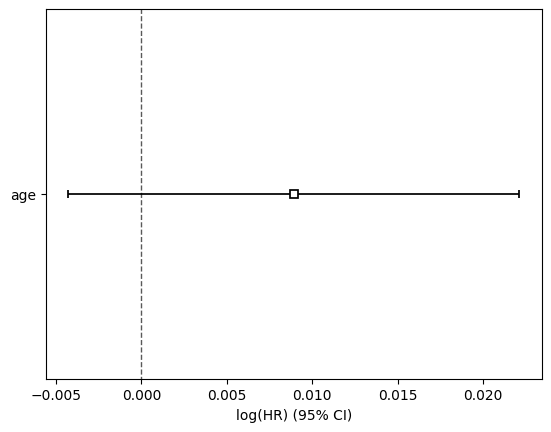

In [17]:
# Use just 'Age Date Dx Liver Cancer' for refit
age_col = 'Age Date Dx Liver Cancer'
X_age = X_nonzero_filtered[[age_col]]

# Prepare data as required by lifelines
df_lf = pd.DataFrame({
    'age': X_age[age_col].values,
    'duration': y['duration'],
    'event': y['event'].astype(int)
})

cph = CoxPHFitter()
cph.fit(df_lf, duration_col='duration', event_col='event')
cph.print_summary()  # Shows HR, 95% CI, and p-value

# You can also plot:
cph.plot()


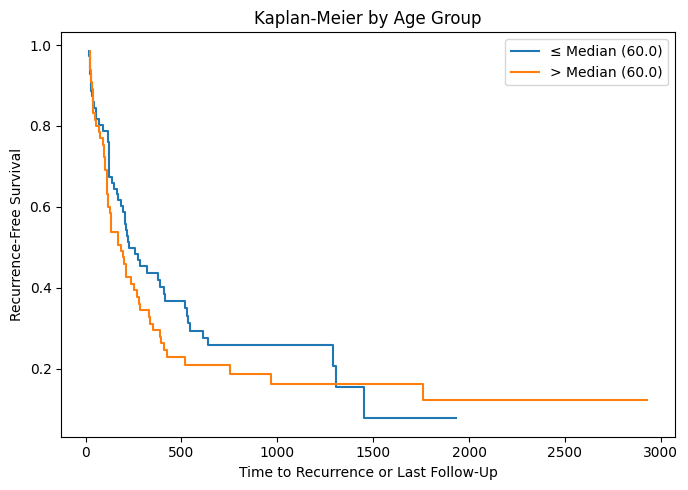

In [18]:
# Split age at median for visualization
median_age = X_age[age_col].median()
age_group = X_age[age_col] > median_age

# Plot KM curves
plt.figure(figsize=(7,5))
for group, label in zip([False, True], [f'≤ Median ({median_age:.1f})', f'> Median ({median_age:.1f})']):
    mask = (age_group == group)
    time, survival_prob = kaplan_meier_estimator(
        y[mask]['event'], y[mask]['duration']
    )
    plt.step(time, survival_prob, label=label)
plt.xlabel('Time to Recurrence or Last Follow-Up')
plt.ylabel('Recurrence-Free Survival')
plt.title('Kaplan-Meier by Age Group')
plt.legend()
plt.tight_layout()
plt.show()


Index(['95% lower-bound', '95% upper-bound'], dtype='object')


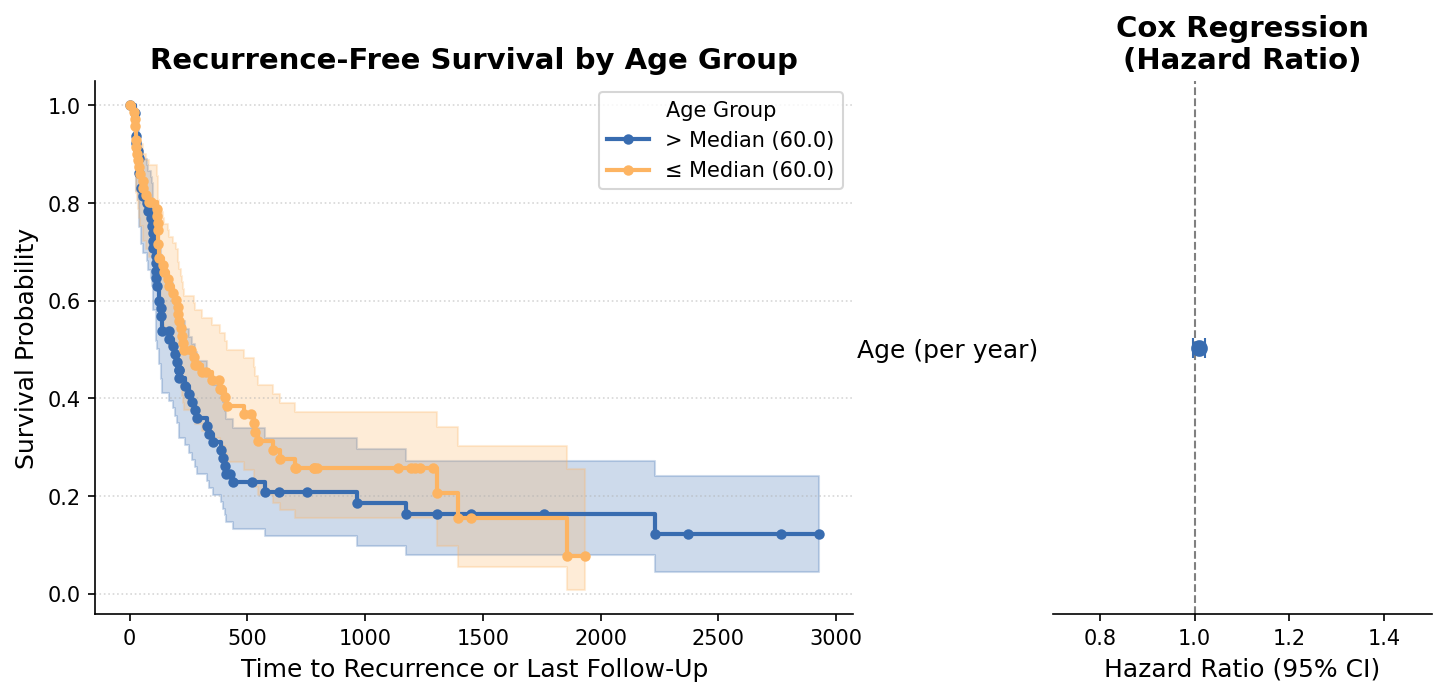

<Figure size 640x480 with 0 Axes>

In [19]:
# Prepare data for lifelines
df_lf = pd.DataFrame({
    'age': X_age[age_col].values,
    'duration': y['duration'],
    'event': y['event'].astype(int)
})

# Stratify by age (median split)
median_age = df_lf['age'].median()
df_lf['age_group'] = np.where(df_lf['age'] > median_age, f'> Median ({median_age:.1f})', f'≤ Median ({median_age:.1f})')

# Fit Cox model
cph = CoxPHFitter()
cph.fit(df_lf[['age', 'duration', 'event']], duration_col='duration', event_col='event')

# Fit KM curves
kmf = KaplanMeierFitter()

fig, axes = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [2, 1]}, dpi=150)

# --- Left: KM Curves ---
ax_km = axes[0]
colors = ['#386cb0', '#fdb462']  # blue and orange for colorblind friendliness

for i, (group, grp_df) in enumerate(df_lf.groupby('age_group')):
    kmf.fit(grp_df['duration'], grp_df['event'], label=group)
    kmf.plot(ax=ax_km, ci_show=True, color=colors[i], lw=2, marker='o', markersize=4)

ax_km.set_title('Recurrence-Free Survival by Age Group', fontsize=14, weight='bold')
ax_km.set_xlabel('Time to Recurrence or Last Follow-Up', fontsize=12)
ax_km.set_ylabel('Survival Probability', fontsize=12)
ax_km.legend(title="Age Group")
ax_km.grid(axis='y', linestyle=':', alpha=0.5)
ax_km.spines['top'].set_visible(False)
ax_km.spines['right'].set_visible(False)

# --- Right: Forest Plot ---
ax_forest = axes[1]

# After fitting model and printing columns:
print(cph.confidence_intervals_.columns)  # Debugging, see actual column names

hr = np.exp(cph.params_['age'])
ci_low = np.exp(cph.confidence_intervals_.iloc[0, 0])
ci_high = np.exp(cph.confidence_intervals_.iloc[0, 1])

# Now your plotting code follows as before


ax_forest.errorbar(hr, 0, xerr=[[hr - ci_low], [ci_high - hr]],
                   fmt='o', color='#386cb0', ecolor='#386cb0', capsize=5, lw=2, markersize=7)
ax_forest.axvline(1, color='grey', linestyle='--', lw=1)
ax_forest.set_yticks([0])
ax_forest.set_yticklabels(['Age (per year)'], fontsize=12)
ax_forest.set_xlabel('Hazard Ratio (95% CI)', fontsize=12)
ax_forest.set_xlim(left=0.7, right=max(ci_high * 1.1, 1.5))
ax_forest.set_title('Cox Regression\n(Hazard Ratio)', fontsize=14, weight='bold')
ax_forest.spines['top'].set_visible(False)
ax_forest.spines['right'].set_visible(False)
ax_forest.spines['left'].set_visible(False)
ax_forest.yaxis.set_ticks_position('none')

# Remove y grid, tidy layout
ax_forest.grid(False)
plt.tight_layout(pad=2)
fig.subplots_adjust(wspace=0.35)
plt.show()
figpath = "Secondary_Tumor_Recurrence.png"
plt.savefig(figpath, dpi=600, bbox_inches='tight')
plt.savefig("Secondary_Tumor_Recurrence.png", dpi=600, bbox_inches='tight')
!cp Secondary_Tumor_Recurrence.png "/content/drive/My Drive/Tommy Rads/"

In [20]:
df = pd.read_csv('/content/drive/MyDrive/Tommy Rads/Primary_Tumor_Recurrence.csv', index_col=False, encoding='latin1')

In [21]:
numeric_cols = df.select_dtypes(include=np.number).columns

# Apply the mask to only the numeric columns
df[numeric_cols] = df[numeric_cols].mask(df[numeric_cols] < 0)

print(df)

    Date Ablation      Last me        ID #     First me         DOB Sex  \
0      12/13/2022  BLAZEJEWSKI  8447467713      DEBORAH   8/29/1958   F   
1       12/7/2022          DAN  8442497517       JUDITH   9/28/1953   F   
2      11/22/2022      STEVENS  8467680070       MELVIN   5/12/1950   M   
3      11/15/2022        PATEL  8466643962  JAYSHREEBEN   10/5/1954   F   
4       11/9/2022        DOLAN  1003888486          LEO   4/17/1946   M   
..            ...          ...         ...          ...         ...  ..   
146     2/19/2015    MCDERMOTT  1003416447        SUSAN    4/9/1954   F   
147     2/17/2015    SILVESTER   445847783      CELESTE   1/14/1948   F   
148     2/13/2015      MCGRATH   444725758        DIANE  10/13/1953   F   
149      2/3/2015       THOMAS  1000535590       MARSHA   4/25/1954   F   
150     1/20/2015       BAILEY     1285048         LOLA   3/23/1958   F   

      Race    Ethnicity CAT type of cancer Date Dx Different Primary  \
0    White  NotHispanic    

In [22]:
# Replace '-' with NaN
df.replace('-', np.nan, inplace=True)

# Helper function to flag unexpected values
def flag_unexpected(series, expected_type, allowed_values=None, pattern=None):
    flagged = []
    for idx, val in series.items():
        if pd.isna(val):
            continue
        if allowed_values is not None and val not in allowed_values:
            flagged.append((idx, val))
        elif expected_type == 'numeric':
            try:
                float(str(val).replace('A','')) # '12A' becomes '12'
            except:
                flagged.append((idx, val))
        elif expected_type == 'binary':
            if str(val) not in ['0', '1']:
                flagged.append((idx, val))
        elif pattern is not None:
            if not re.match(pattern, str(val)):
                flagged.append((idx, val))
    return flagged

# Cleaning report dictionary
cleaning_report = {}

# Sex: Recode to binary Sex: Male
df['Sex'] = df['Sex'].str.strip().str.upper().replace({'MALE': 'M', 'FEMALE': 'F'})
sex_binary = df['Sex'].map({'M': 1, 'F': 0})
df['Sex: Male'] = sex_binary
cleaning_report['Sex'] = flag_unexpected(df['Sex'], 'str', allowed_values=['M', 'F'])

# Race
allowed_races = ['White', 'Black', 'Asian', 'Other', 'Unknown']
df['Race'] = df['Race'].astype(str).str.strip().str.title()
cleaning_report['Race'] = flag_unexpected(df['Race'], 'str', allowed_values=allowed_races)

# Ethnicity
allowed_ethnicities = ['Hispanic', 'Nothispanic', 'Unknown']
df['Ethnicity'] = df['Ethnicity'].astype(str).str.strip().str.title()
cleaning_report['Ethnicity'] = flag_unexpected(df['Ethnicity'], 'str', allowed_values=allowed_ethnicities)

# Type of cancer
df['CAT type of cancer'] = df['CAT type of cancer'].astype(str).str.strip().str.lower()

# Age
df['Age Date Dx Liver Cancer'] = pd.to_numeric(df['Age Date Dx Liver Cancer'], errors='coerce')
cleaning_report['Age Date Dx Liver Cancer'] = flag_unexpected(df['Age Date Dx Liver Cancer'], 'numeric')

# CAT HCV
allowed_hcv = [0, 2]
df['CAT HCV (2SVR, 1 for chronic/present, 3 HBV 4 HAV)'] = pd.to_numeric(
    df['CAT HCV (2SVR, 1 for chronic/present, 3 HBV 4 HAV)'], errors='coerce'
)
cleaning_report['CAT HCV'] = flag_unexpected(
    df['CAT HCV (2SVR, 1 for chronic/present, 3 HBV 4 HAV)'], 'numeric', allowed_values=allowed_hcv)

# Define a mapping of scores to integers
score_mapping = {
    '5': 1,
    '6': 2,
    '7': 3,
    '8': 4,
    '9': 5,
    '10': 6,
    '11': 7,
    '12': 8,
    '13': 9,
    '14': 10,
    '15': 11
}

# Function to extract the relevant score from the string, while handling NaN values
def extract_score(text):
    if isinstance(text, str):  # Check if the entry is a string
        for score in score_mapping:
            if re.search(score, text):
                return score
    return None  # Return None if NaN or no match is found

# Apply the function to extract the score and then map it to the integer value
df['SCALAR CPT Score (Extracted)'] = df['SCALAR CPT Score'].apply(extract_score)
df['SCALAR CPT Score (Recode)'] = df['SCALAR CPT Score (Extracted)'].map(score_mapping)

# Binary columns
binary_cols = ['EtOH', 'NASH', 'Ascites', 'Encephalopathy', 'First AFP Elevated',
               'Unilobar (0), Bilobar (1)', 'Bx during ablation (0no, 1yes, 2NGS)']
for col in binary_cols:
    allowed = ['0', '1'] if 'Bx during ablation' not in col else ['0', '1', '2']
    df[col] = df[col].astype(str).str.strip()
    df[col].replace('', np.nan, inplace=True)
    cleaning_report[col] = flag_unexpected(df[col], 'binary', allowed_values=allowed)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Scalar numeric columns
scalar_cols = ['WBC', 'Hgb', 'Plt', 'Na', 'Cr', 'Albumin', 'Tbili', 'INR', 'AFP1',
               '#tumors to ablate', 'Longest Diameter Largest lesion (mm)',
               'Sum Longest Diameters', 'PS', 'Time to recur', 'SCALAR CPT Score (Recode)', 'First ablation total energy']
for col in scalar_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    cleaning_report[col] = flag_unexpected(df[col], 'numeric')

# Segment Largest Index Lesion (integer, sometimes with an 'A' suffix)
def clean_segment(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, str) and x.endswith('A'):
        x = x[:-1]
    try:
        return int(x)
    except:
        return np.nan
df['Segment Largest Index Lesion'] = df['Segment Largest Index Lesion'].apply(clean_segment)
cleaning_report['Segment Largest Index Lesion'] = flag_unexpected(df['Segment Largest Index Lesion'], 'numeric')

/tmp/ipython-input-22-2545173375.py:92: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace('', np.nan, inplace=True)
/tmp/ipython-input-22-2545173375.py:92: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

In [23]:
# Liver Treatment prior to initial ablation
treatment_map = {
    '1': 'TACE',
    '2': 'TARE',
    '3': 'EBRT',
    '4': 'Systemic Therapy',
    '5': 'Resection',
    '6': 'Combined/Other'
}
def treatment_flags(cell):
    flags = {name: 0 for name in treatment_map.values()}
    if pd.isna(cell):
        return pd.Series(flags)
    items = re.findall(r'\d', str(cell))
    for item in items:
        if item in treatment_map:
            flags[treatment_map[item]] = 1
    return pd.Series(flags)
treatments = df['CAT Liver Treatment prior to initial ablation (0none, 1TACE, 2TARE, 3EBRT, 4Systemic Therapy, 5resection, 6bland embo/other)'].apply(treatment_flags)
df = pd.concat([df, treatments], axis=1)
df.drop(columns=['CAT Liver Treatment prior to initial ablation (0none, 1TACE, 2TARE, 3EBRT, 4Systemic Therapy, 5resection, 6bland embo/other)'], inplace=True)

# Recur (dependent)
df['Recur (0no, 1yes)'] = pd.to_numeric(df['Recur (0no, 1yes)'], errors='coerce')
cleaning_report['Recur (0no, 1yes)'] = flag_unexpected(df['Recur (0no, 1yes)'], 'binary', allowed_values=['0', '1'])

# Gather cleaning report and summarize any flagged values
flagged_summary = {col: flagged for col, flagged in cleaning_report.items() if flagged}
flagged_summary  # Show all columns with flagged/unexpected values and what those are


{'CAT HCV': [(8, 1),
  (14, 3),
  (21, 3),
  (22, 3),
  (37, 3),
  (45, 1),
  (49, 3),
  (52, 3),
  (54, 1),
  (56, 1),
  (60, 3),
  (61, 1),
  (65, 1),
  (66, 4),
  (68, 1),
  (71, 1),
  (73, 1),
  (79, 1),
  (80, 1),
  (83, 1),
  (84, 3),
  (86, 1),
  (90, 1),
  (92, 1),
  (100, 1),
  (105, 1),
  (106, 1),
  (108, 3),
  (109, 3),
  (111, 3),
  (112, 3),
  (113, 3),
  (115, 3),
  (118, 3),
  (120, 1),
  (124, 1),
  (126, 1),
  (131, 1),
  (132, 1),
  (141, 1),
  (143, 1),
  (144, 1),
  (147, 1),
  (149, 1),
  (150, 1)],
 'EtOH': [(59, '2')],
 'Ascites': [(0, '2'), (27, '2'), (36, '2'), (83, '2'), (90, '2'), (133, '2')],
 'Encephalopathy': [(23, '2'), (83, '2')],
 'Recur (0no, 1yes)': [(0, 1),
  (1, 0),
  (2, 0),
  (3, 0),
  (4, 0),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 0),
  (9, 0),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 0),
  (14, 1),
  (15, 0),
  (16, 1),
  (17, 0),
  (18, 1),
  (19, 0),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 0),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1)

In [24]:
# First CEA Elevated: Recode to binary integers
df['First AFP Elevated'] = df['First AFP Elevated'].replace({'1.0': 1, '0.0': 0}).astype(float)
# (Leave np.nan for missing)

# Bx during ablation: Create one-hot columns for Yes (1) and NGS (2)
df['Bx during ablation: Yes'] = (df['Bx during ablation (0no, 1yes, 2NGS)'] == 1).astype(int)
df['Bx during ablation: NGS'] = (df['Bx during ablation (0no, 1yes, 2NGS)'] == 2).astype(int)

df['First ablation probe: PR15'] = (df['First ablation probe'] == 'PR15').astype(int)
df['First ablation probe: PR15'] = (df['First ablation probe'] == 'PR').astype(int)
df['First ablation probe: PR20'] = (df['First ablation probe'] == 'PR20').astype(int)
df['First ablation probe: LK'] = (df['First ablation probe'] == 'LK').astype(int)
df['First ablation probe: Solaris'] = (df['First ablation probe'] == 'Solaris').astype(int)

# Show the first 10 rows of the cleaned dataframe for relevant columns
df[['First AFP Elevated', 'Bx during ablation (0no, 1yes, 2NGS)',
    'Bx during ablation: Yes', 'Bx during ablation: NGS']].head(10)

,First AFP Elevated,"Bx during ablation (0no, 1yes, 2NGS)",Bx during ablation: Yes,Bx during ablation: NGS
0,0.0,0,0,0
1,0.0,0,0,0
2,0.0,1,1,0
3,0.0,0,0,0
4,0.0,0,0,0
5,0.0,0,0,0
6,0.0,0,0,0
7,1.0,1,1,0
8,1.0,0,0,0
9,0.0,0,0,0


In [25]:
# Define columns
scalar_cols = [
    'Age Date Dx Liver Cancer', 'WBC', 'Hgb', 'Plt', 'Na', 'Cr', 'Albumin', 'Tbili', 'INR', 'First ablation total energy',
    'AFP1', '#tumors to ablate', 'Longest Diameter Largest lesion (mm)', 'Sum Longest Diameters', 'PS', 'SCALAR CPT Score (Recode)'
]
binary_cols = [
    'Sex: Male', 'EtOH', 'NASH', 'Ascites', 'Encephalopathy', 'First AFP Elevated',
    'Unilobar (0), Bilobar (1)', 'Bx during ablation: Yes', 'Bx during ablation: NGS', 'First ablation probe: PR15',
    'First ablation probe: PR20', 'First ablation probe: LK', 'First ablation probe: Solaris','Recur (0no, 1yes)',
    'TACE',	'TARE',	'EBRT',	'Systemic Therapy',	'Resection',	'Combined/Other'
]
categorical_cols = [
    'Race', 'Ethnicity', 'CAT type of cancer', 'CAT HCV (2SVR, 1 for chronic/present, 3 HBV 4 HAV)'
]

# Check scalar columns: should be numeric or NaN
scalar_issues = {}
for col in scalar_cols:
    not_scalar = df[~df[col].isna() & ~df[col].apply(lambda x: isinstance(x, (int, float)))][col]
    if not not_scalar.empty:
        scalar_issues[col] = not_scalar.unique().tolist()

# Check binary columns: should be 0, 1, or NaN
binary_issues = {}
for col in binary_cols:
    vals = set(df[col].dropna().unique())
    if not vals.issubset({0, 1}):
        binary_issues[col] = vals - {0, 1}

# Check categorical columns: show all unique values
categorical_uniques = {col: df[col].dropna().unique().tolist() for col in categorical_cols}

(scalar_issues, binary_issues, categorical_uniques)

df.to_csv("Primary_Tumors_Cleaned.csv", index=False)
!cp Primary_Tumors_Cleaned.csv "/content/drive/My Drive/Tommy Rads/"

In [26]:
# Exclude dependent variable from imputation
impute_cols = [col for col in (scalar_cols + binary_cols) if col != 'Recur (0no, 1yes)']

# Prepare input for imputation
impute_df = df[impute_cols]

# MICE imputation
mice = IterativeImputer(random_state=42, sample_posterior=True, max_iter=20)
imputed_array = mice.fit_transform(impute_df)
imputed_df = pd.DataFrame(imputed_array, columns=impute_cols, index=impute_df.index)

# Restore binary columns as integer 0/1
for col in binary_cols:
    if col in imputed_df.columns:
        imputed_df[col] = imputed_df[col].round().astype(int)

# Add back categorical and dependent columns, in original order
final_df = pd.concat(
    [imputed_df, df[categorical_cols + ['CAT type of cancer', 'Recur (0no, 1yes)']]],
    axis=1
)

# Show head and check remaining NaNs
(final_df.head(), final_df.isna().sum())

(   Age Date Dx Liver Cancer   WBC   Hgb    Plt     Na   Cr  Albumin  Tbili  \
 0                      63.0   4.0  11.0   89.0  140.0  1.0      4.0    1.0   
 1                      68.0   6.0  13.0   93.0  138.0  1.0      3.0    2.0   
 2                      72.0   6.0  13.0  108.0  135.0  1.0      4.0    1.0   
 3                      67.0  10.0  12.0  152.0  136.0  0.0      3.0    1.0   
 4                      76.0   4.0  14.0  109.0  141.0  1.0      4.0    1.0   
 
    INR  First ablation total energy        AFP1  #tumors to ablate  \
 0  1.0                       1300.0  169.741875                2.0   
 1  1.0                        650.0    2.400000                1.0   
 2  1.0                       1850.0    4.500000                1.0   
 3  1.0                       1300.0    7.200000                1.0   
 4  1.0                        650.0    5.000000                1.0   
 
    Longest Diameter Largest lesion (mm)  Sum Longest Diameters   PS  \
 0                      

In [27]:
# Drop duplicate columns, if any (from prior concatenation)
final_df = final_df.loc[:,~final_df.columns.duplicated()]

# Define categorical columns
categorical_cols = ['Race', 'Ethnicity', 'CAT type of cancer', 'CAT HCV (2SVR, 1 for chronic/present, 3 HBV 4 HAV)']

# One-hot encode, drop first to avoid collinearity
final_encoded = pd.get_dummies(final_df, columns=categorical_cols, drop_first=True)

# Show shape and column sample
(final_encoded.shape, final_encoded.columns.tolist()[:12])

((151, 47),
 ['Age Date Dx Liver Cancer',
  'WBC',
  'Hgb',
  'Plt',
  'Na',
  'Cr',
  'Albumin',
  'Tbili',
  'INR',
  'First ablation total energy',
  'AFP1',
  '#tumors to ablate'])

In [28]:
final_encoded.head()

,Age Date Dx Liver Cancer,WBC,Hgb,Plt,Na,Cr,Albumin,Tbili,INR,First ablation total energy,AFP1,#tumors to ablate,Longest Diameter Largest lesion (mm),Sum Longest Diameters,PS,SCALAR CPT Score (Recode),Sex: Male,EtOH,NASH,Ascites,Encephalopathy,First AFP Elevated,"Unilobar (0), Bilobar (1)",Bx during ablation: Yes,Bx during ablation: NGS,First ablation probe: PR15,First ablation probe: PR20,First ablation probe: LK,First ablation probe: Solaris,TACE,TARE,EBRT,Systemic Therapy,Resection,Combined/Other,"Recur (0no, 1yes)",Race_Black,Race_Other,Race_Unknown,Race_White,Ethnicity_Nothispanic,CAT type of cancer_hcc,CAT type of cancer_hepatocholangiocc,"CAT HCV (2SVR, 1 for chronic/present, 3 HBV 4 HAV)_1","CAT HCV (2SVR, 1 for chronic/present, 3 HBV 4 HAV)_2","CAT HCV (2SVR, 1 for chronic/present, 3 HBV 4 HAV)_3","CAT HCV (2SVR, 1 for chronic/present, 3 HBV 4 HAV)_4"
0,63.0,4.0,11.0,89.0,140.0,1.0,4.0,1.0,1.0,1300.0,169.741875,2.0,26.0,48.0,1.0,1.000000,0,0,0,2,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,False,False,False,True,True,False,False,False,False,False,False
1,68.0,6.0,13.0,93.0,138.0,1.0,3.0,2.0,1.0,650.0,2.400000,1.0,30.0,30.0,1.0,5.000000,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,False,False,False,True,True,True,False,False,False,False,False
2,72.0,6.0,13.0,108.0,135.0,1.0,4.0,1.0,1.0,1850.0,4.500000,1.0,20.0,20.0,1.0,2.000000,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,False,False,False,True,True,True,False,False,False,False,False
3,67.0,10.0,12.0,152.0,136.0,0.0,3.0,1.0,1.0,1300.0,7.200000,1.0,23.0,23.0,1.0,1.000000,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,False,False,False,False,True,True,False,False,False,False,False
4,76.0,4.0,14.0,109.0,141.0,1.0,4.0,1.0,1.0,650.0,5.000000,1.0,20.0,20.0,1.0,1.966146,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,False,True,True,True,False,False,False,False,False


In [29]:
final_encoded.to_csv("Primary_Tumors_Cleaned_debug.csv", index=False)
!cp Primary_Tumors_Cleaned_debug.csv "/content/drive/My Drive/Tommy Rads/"

In [30]:
# Build duration and event columns for Cox model
cox_df = final_encoded.copy()
# Use event: 1 if recurred, 0 if censored
cox_df['event'] = cox_df['Recur (0no, 1yes)']

# Duration: 'Time to recur' if event, else 'Days between follow up and first ablation'
# Ensure both are numeric
cox_df['Time to recur'] = pd.to_numeric(df['Time to recur'], errors='coerce')
cox_df['Days between follow up and first ablation'] = pd.to_numeric(df['Days between follow up and first ablation'], errors='coerce')

cox_df['duration'] = np.where(
    cox_df['event'] == 1,
    cox_df['Time to recur'],
    cox_df['Days between follow up and first ablation']
)

# Cap duration at 10 years (3650 days)
cox_df['duration'] = cox_df['duration'].clip(upper=3650)

# Drop any rows missing duration or event
cox_df = cox_df.dropna(subset=['duration', 'event'])

# One-hot encode categorical variables (and treatment columns if not binary already)
categorical_cols = [
    'Race', 'Ethnicity', 'type of cancer', 'CAT HCV (2SVR, 1 for chronic/present, 3 HBV 4 HAV)',
    'TACE', 'TARE', 'EBRT', 'Systemic Therapy', 'Resection', 'Combined/Other'
]
# Only include those that exist (sometimes a treatment might not be present in this subset)
categorical_cols = [col for col in categorical_cols if col in cox_df.columns]

cox_encoded = pd.get_dummies(cox_df, columns=categorical_cols, drop_first=True)

# Drop extra time columns from predictors
for drop_col in ['Time to recur', 'Days between follow up and first ablation', 'Recur (0no, 1yes)']:
    if drop_col in cox_encoded.columns:
        cox_encoded = cox_encoded.drop(columns=[drop_col])

# Show ready-for-cox head and shape
cox_encoded[['duration', 'event']].head(), cox_encoded.shape


(   duration  event
 0      31.0      1
 1     203.0      0
 2     218.0      0
 3     129.0      0
 4      65.0      0,
 (149, 48))

In [31]:
# Prepare predictors (X) and outcome (y)
X = cox_encoded.drop(columns=['duration', 'event'])
y = np.array([(bool(e), d) for e, d in zip(cox_encoded['event'], cox_encoded['duration'])],
             dtype=[('event', 'bool'), ('duration', 'float')])

# Remove columns with zero variance
X = pd.DataFrame(X, columns=X.columns)  # ensure DataFrame
nonzero_var_cols = X.std(axis=0) > 0
X_nonzero = X.loc[:, nonzero_var_cols]

# Define threshold for rare variable (e.g., fewer than 10 positive cases)
min_count = 10

# Identify rare one-hot columns (dummy variables)
rare_cols = [col for col in X_nonzero.columns if (X_nonzero[col].sum() < min_count)]

print("Rare columns to drop/collapse:", rare_cols)

# Drop rare columns
X_nonzero_filtered = X_nonzero.drop(columns=rare_cols)
filtered_features = X_nonzero_filtered.columns.tolist()

# Print how many features remain
print(f"Features after dropping rare dummies: {len(filtered_features)} (dropped {len(rare_cols)})")

full_features = X_nonzero_filtered.columns.tolist()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_nonzero_filtered)

print("Full feature count (after dropping zero-variance):", len(full_features))
print("First 5 features:", full_features[:5])

# Lasso-penalized Cox (L1 only)
model = CoxnetSurvivalAnalysis(l1_ratio=1.0, n_alphas=50, alpha_min_ratio=0.05, max_iter=5000, fit_baseline_model=True)
model.fit(X_scaled, y)

# Get predictions and coefficients for each alpha in the regularization path
scores = []
for i, alpha in enumerate(model.alphas_):
    pred = model.predict(X_scaled, alpha=alpha)
    c_index = concordance_index_censored(
        cox_encoded['event'].astype(bool),
        cox_encoded['duration'],
        pred
    )[0]
    coef = model.coef_[:, i]
    scores.append((alpha, c_index, coef))

# Select best alpha (highest C-index)
best_alpha, best_cindex, best_coef = max(scores, key=lambda t: t[1])
selected = best_coef != 0
selected_features = X_nonzero_filtered.columns[selected]
selected_coefs = best_coef[selected]

# Refit model with best alpha
final_model = CoxnetSurvivalAnalysis(l1_ratio=1.0, alphas=[best_alpha], max_iter=5000)
final_model.fit(X_scaled, y)

print("\nBest alpha (lambda):", best_alpha)
print("Best C-index:", best_cindex)
print("Selected features and coefficients (nonzero):")
for name, val in zip(selected_features, selected_coefs):
    print(f"{name:40s} {val: .3f}")

# Print zero-variance check on standardized data
print((X_scaled.std(axis=0) == 0).sum(), "columns with zero variance after scaling")

# ---- BOOTSTRAP VALIDATION ----

n_bootstraps = 200
selection_counts = np.zeros(len(full_features))
my_bootstrap_alpha = best_alpha / 10

for i in tqdm(range(n_bootstraps)):
    idx = np.random.choice(X_nonzero_filtered.shape[0], size=X_nonzero_filtered.shape[0], replace=True)
    X_boot = X_nonzero_filtered.iloc[idx, :].copy()
    y_boot = y[idx]

    # Guarantee all columns are present, in the same order, even if missing from this resample
    for col in full_features:
        if col not in X_boot:
            X_boot[col] = 0  # fill with zeros

    # Re-order columns to match full_features
    X_boot = X_boot[full_features]

    # Now standardize (do NOT re-fit, just transform)
    X_boot_scaled = scaler.transform(X_boot)

    try:
        boot_model = CoxnetSurvivalAnalysis(l1_ratio=1.0, alphas=[my_bootstrap_alpha], max_iter=5000)
        boot_model.fit(X_boot_scaled, y_boot)
        model_feats = X_boot.columns
        boot_coef = pd.Series(0.0, index=full_features)  # force float for compatibility
        for coef_val, feat in zip(boot_model.coef_[0], model_feats):
            boot_coef[feat] = coef_val
        selection_counts += (boot_coef != 0).values
        print(f"Boot {i}: selected features: {boot_coef[boot_coef != 0].index.tolist()}")
    except Exception as e:
        print(f"Bootstrap {i} failed: {e}")

selection_freq = selection_counts / n_bootstraps
selected_features_df = pd.DataFrame({
    'feature': full_features,
    'selection_freq': selection_freq
}).sort_values('selection_freq', ascending=False)

print("\nFeatures selected in at least one bootstrap:")
print(selected_features_df[selected_features_df.selection_freq > 0])


Rare columns to drop/collapse: ['First ablation probe: PR15', 'First ablation probe: PR20', 'Race_Other', 'Race_Unknown', 'CAT type of cancer_hepatocholangiocc', 'CAT HCV (2SVR, 1 for chronic/present, 3 HBV 4 HAV)_4', 'TARE_1', 'Combined/Other_1']
Features after dropping rare dummies: 36 (dropped 8)
Full feature count (after dropping zero-variance): 36
First 5 features: ['Age Date Dx Liver Cancer', 'WBC', 'Hgb', 'Plt', 'Na']

Best alpha (lambda): 0.008780922314132194
Best C-index: 0.752847773558854
Selected features and coefficients (nonzero):
WBC                                       0.052
Hgb                                      -0.083
Plt                                      -0.011
Na                                        0.203
Cr                                       -0.348
Albumin                                   0.064
Tbili                                    -0.285
INR                                       0.249
First ablation total energy               0.163
AFP1              

  2%|▏         | 3/200 [00:00<00:11, 16.58it/s]

Boot 0: selected features: ['Age Date Dx Liver Cancer']
Boot 1: selected features: ['Age Date Dx Liver Cancer']
Boot 2: selected features: ['Age Date Dx Liver Cancer']
Boot 3: selected features: ['Age Date Dx Liver Cancer']


  3%|▎         | 6/200 [00:00<00:09, 21.02it/s]

Boot 4: selected features: ['Age Date Dx Liver Cancer']
Boot 5: selected features: ['Age Date Dx Liver Cancer']
Boot 6: selected features: ['Age Date Dx Liver Cancer']
Boot 7: selected features: []


  4%|▍         | 9/200 [00:00<00:09, 19.43it/s]

Boot 8: selected features: ['Age Date Dx Liver Cancer']
Boot 9: selected features: ['Age Date Dx Liver Cancer']


  6%|▌         | 12/200 [00:00<00:11, 16.01it/s]

Boot 10: selected features: ['Age Date Dx Liver Cancer']
Boot 11: selected features: ['Age Date Dx Liver Cancer']
Boot 12: selected features: ['Age Date Dx Liver Cancer']


  8%|▊         | 15/200 [00:00<00:09, 18.94it/s]

Boot 13: selected features: ['Age Date Dx Liver Cancer']
Boot 14: selected features: ['Age Date Dx Liver Cancer']
Boot 15: selected features: ['Age Date Dx Liver Cancer']


  9%|▉         | 18/200 [00:00<00:09, 18.67it/s]

Boot 16: selected features: ['Age Date Dx Liver Cancer']
Boot 17: selected features: ['Age Date Dx Liver Cancer']
Boot 18: selected features: ['Age Date Dx Liver Cancer']


 10%|█         | 21/200 [00:01<00:09, 19.49it/s]

Boot 19: selected features: ['Age Date Dx Liver Cancer']
Boot 20: selected features: ['Age Date Dx Liver Cancer']
Boot 21: selected features: ['Age Date Dx Liver Cancer']


 12%|█▏        | 24/200 [00:01<00:10, 16.57it/s]

Boot 22: selected features: ['Age Date Dx Liver Cancer']
Boot 23: selected features: ['Age Date Dx Liver Cancer']
Boot 24: selected features: ['Age Date Dx Liver Cancer']


 14%|█▍        | 28/200 [00:01<00:10, 16.17it/s]

Boot 25: selected features: ['Age Date Dx Liver Cancer']
Boot 26: selected features: ['Age Date Dx Liver Cancer']
Boot 27: selected features: ['Age Date Dx Liver Cancer']
Boot 28: selected features: ['Age Date Dx Liver Cancer']


 16%|█▌        | 32/200 [00:01<00:10, 16.64it/s]

Boot 29: selected features: ['Age Date Dx Liver Cancer']
Boot 30: selected features: ['Age Date Dx Liver Cancer']
Boot 31: selected features: ['Age Date Dx Liver Cancer']
Boot 32: selected features: ['Age Date Dx Liver Cancer']
Boot 33: selected features: ['Age Date Dx Liver Cancer']


 20%|██        | 40/200 [00:02<00:06, 24.18it/s]

Boot 34: selected features: ['Age Date Dx Liver Cancer']
Boot 35: selected features: ['Age Date Dx Liver Cancer']
Boot 36: selected features: ['Age Date Dx Liver Cancer']
Boot 37: selected features: ['Age Date Dx Liver Cancer']
Boot 38: selected features: ['Age Date Dx Liver Cancer']
Boot 39: selected features: ['Age Date Dx Liver Cancer']


 22%|██▏       | 43/200 [00:02<00:08, 19.34it/s]

Boot 40: selected features: ['Age Date Dx Liver Cancer']
Boot 41: selected features: ['Age Date Dx Liver Cancer']
Boot 42: selected features: ['Age Date Dx Liver Cancer']


 23%|██▎       | 46/200 [00:02<00:07, 19.98it/s]

Boot 43: selected features: ['Age Date Dx Liver Cancer']
Boot 44: selected features: ['Age Date Dx Liver Cancer']
Boot 45: selected features: ['Age Date Dx Liver Cancer']
Boot 46: selected features: ['Age Date Dx Liver Cancer']
Boot 47: selected features: ['Age Date Dx Liver Cancer']


 26%|██▌       | 52/200 [00:02<00:07, 19.31it/s]

Boot 48: selected features: []
Boot 49: selected features: ['Age Date Dx Liver Cancer']
Boot 50: selected features: ['Age Date Dx Liver Cancer']
Boot 51: selected features: ['Age Date Dx Liver Cancer']


 28%|██▊       | 57/200 [00:02<00:05, 25.13it/s]

Boot 52: selected features: []
Boot 53: selected features: ['Age Date Dx Liver Cancer']
Boot 54: selected features: ['Age Date Dx Liver Cancer']
Boot 55: selected features: ['Age Date Dx Liver Cancer']
Boot 56: selected features: ['Age Date Dx Liver Cancer']
Boot 57: selected features: ['Age Date Dx Liver Cancer']
Boot 58: selected features: ['Age Date Dx Liver Cancer']
Boot 59: selected features: ['Age Date Dx Liver Cancer']
Boot 60: selected features: ['Age Date Dx Liver Cancer']


 33%|███▎      | 66/200 [00:03<00:04, 29.63it/s]

Boot 61: selected features: ['Age Date Dx Liver Cancer']
Boot 62: selected features: ['Age Date Dx Liver Cancer']
Boot 63: selected features: ['Age Date Dx Liver Cancer']
Boot 64: selected features: ['Age Date Dx Liver Cancer']
Boot 65: selected features: ['Age Date Dx Liver Cancer']


 35%|███▌      | 70/200 [00:03<00:04, 26.48it/s]

Boot 66: selected features: ['Age Date Dx Liver Cancer']
Boot 67: selected features: ['Age Date Dx Liver Cancer']
Boot 68: selected features: ['Age Date Dx Liver Cancer']
Boot 69: selected features: ['Age Date Dx Liver Cancer']
Boot 70: selected features: ['Age Date Dx Liver Cancer']
Boot 71: selected features: ['Age Date Dx Liver Cancer']


/tmp/ipython-input-31-3761651437.py:94: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=5000).
  boot_model.fit(X_boot_scaled, y_boot)
 40%|███▉      | 79/200 [00:03<00:04, 27.77it/s]

Boot 72: selected features: ['Age Date Dx Liver Cancer']
Boot 73: selected features: ['Age Date Dx Liver Cancer']
Boot 74: selected features: ['Age Date Dx Liver Cancer']
Boot 75: selected features: ['Age Date Dx Liver Cancer']
Boot 76: selected features: ['Age Date Dx Liver Cancer']
Boot 77: selected features: ['Age Date Dx Liver Cancer']
Boot 78: selected features: ['Age Date Dx Liver Cancer']
Boot 79: selected features: ['Age Date Dx Liver Cancer']


 44%|████▍     | 88/200 [00:03<00:03, 33.51it/s]

Boot 80: selected features: ['Age Date Dx Liver Cancer']
Boot 81: selected features: ['Age Date Dx Liver Cancer']
Boot 82: selected features: ['Age Date Dx Liver Cancer']
Boot 83: selected features: []
Boot 84: selected features: ['Age Date Dx Liver Cancer']
Boot 85: selected features: ['Age Date Dx Liver Cancer']
Boot 86: selected features: ['Age Date Dx Liver Cancer']
Boot 87: selected features: ['Age Date Dx Liver Cancer']
Boot 88: selected features: []


 50%|████▉     | 99/200 [00:04<00:02, 41.48it/s]

Boot 89: selected features: ['Age Date Dx Liver Cancer']
Boot 90: selected features: ['Age Date Dx Liver Cancer']
Boot 91: selected features: ['Age Date Dx Liver Cancer']
Boot 92: selected features: ['Age Date Dx Liver Cancer']
Boot 93: selected features: ['Age Date Dx Liver Cancer']
Boot 94: selected features: ['Age Date Dx Liver Cancer']
Boot 95: selected features: ['Age Date Dx Liver Cancer']
Boot 96: selected features: ['Age Date Dx Liver Cancer']
Boot 97: selected features: ['Age Date Dx Liver Cancer']
Boot 98: selected features: ['Age Date Dx Liver Cancer']
Boot 99: selected features: ['Age Date Dx Liver Cancer']


 55%|█████▌    | 110/200 [00:04<00:02, 42.42it/s]

Boot 100: selected features: ['Age Date Dx Liver Cancer']
Boot 101: selected features: ['Age Date Dx Liver Cancer']
Boot 102: selected features: ['Age Date Dx Liver Cancer']
Boot 103: selected features: ['Age Date Dx Liver Cancer']
Boot 104: selected features: ['Age Date Dx Liver Cancer']
Boot 105: selected features: ['Age Date Dx Liver Cancer']
Boot 106: selected features: ['Age Date Dx Liver Cancer']
Boot 107: selected features: ['Age Date Dx Liver Cancer']
Boot 108: selected features: ['Age Date Dx Liver Cancer']
Boot 109: selected features: ['Age Date Dx Liver Cancer']


 58%|█████▊    | 116/200 [00:04<00:01, 45.61it/s]

Boot 110: selected features: ['Age Date Dx Liver Cancer']
Boot 111: selected features: ['Age Date Dx Liver Cancer']
Boot 112: selected features: ['Age Date Dx Liver Cancer']
Boot 113: selected features: ['Age Date Dx Liver Cancer']
Boot 114: selected features: ['Age Date Dx Liver Cancer']
Boot 115: selected features: ['Age Date Dx Liver Cancer']
Boot 116: selected features: ['Age Date Dx Liver Cancer']
Boot 117: selected features: ['Age Date Dx Liver Cancer']
Boot 118: selected features: ['Age Date Dx Liver Cancer']


 60%|██████    | 121/200 [00:04<00:01, 41.25it/s]

Boot 119: selected features: ['Age Date Dx Liver Cancer']
Boot 120: selected features: ['Age Date Dx Liver Cancer']
Boot 121: selected features: ['Age Date Dx Liver Cancer']
Boot 122: selected features: ['Age Date Dx Liver Cancer']
Boot 123: selected features: ['Age Date Dx Liver Cancer']
Boot 124: selected features: ['Age Date Dx Liver Cancer']


 66%|██████▌   | 132/200 [00:04<00:01, 37.45it/s]

Boot 125: selected features: ['Age Date Dx Liver Cancer']
Boot 126: selected features: ['Age Date Dx Liver Cancer']
Boot 127: selected features: ['Age Date Dx Liver Cancer']
Boot 128: selected features: ['Age Date Dx Liver Cancer']
Boot 129: selected features: ['Age Date Dx Liver Cancer']
Boot 130: selected features: ['Age Date Dx Liver Cancer']
Boot 131: selected features: ['Age Date Dx Liver Cancer']
Boot 132: selected features: ['Age Date Dx Liver Cancer']
Boot 133: selected features: ['Age Date Dx Liver Cancer']


 70%|███████   | 140/200 [00:05<00:01, 34.34it/s]

Boot 134: selected features: ['Age Date Dx Liver Cancer']
Boot 135: selected features: ['Age Date Dx Liver Cancer']
Boot 136: selected features: ['Age Date Dx Liver Cancer']
Boot 137: selected features: ['Age Date Dx Liver Cancer']
Boot 138: selected features: ['Age Date Dx Liver Cancer']
Boot 139: selected features: ['Age Date Dx Liver Cancer']
Boot 140: selected features: ['Age Date Dx Liver Cancer']
Boot 141: selected features: ['Age Date Dx Liver Cancer']


 74%|███████▍  | 149/200 [00:05<00:01, 34.99it/s]

Boot 142: selected features: ['Age Date Dx Liver Cancer']
Boot 143: selected features: ['Age Date Dx Liver Cancer']
Boot 144: selected features: ['Age Date Dx Liver Cancer']
Boot 145: selected features: ['Age Date Dx Liver Cancer']
Boot 146: selected features: ['Age Date Dx Liver Cancer']
Boot 147: selected features: ['Age Date Dx Liver Cancer']
Boot 148: selected features: ['Age Date Dx Liver Cancer']
Boot 149: selected features: ['Age Date Dx Liver Cancer']


 78%|███████▊  | 157/200 [00:05<00:01, 35.94it/s]

Boot 150: selected features: ['Age Date Dx Liver Cancer']
Boot 151: selected features: ['Age Date Dx Liver Cancer']
Boot 152: selected features: ['Age Date Dx Liver Cancer']
Boot 153: selected features: ['Age Date Dx Liver Cancer']
Boot 154: selected features: ['Age Date Dx Liver Cancer']
Boot 155: selected features: ['Age Date Dx Liver Cancer']
Boot 156: selected features: ['Age Date Dx Liver Cancer']
Boot 157: selected features: ['Age Date Dx Liver Cancer']


 80%|████████  | 161/200 [00:05<00:01, 35.55it/s]

Boot 158: selected features: ['Age Date Dx Liver Cancer']
Boot 159: selected features: ['Age Date Dx Liver Cancer']
Boot 160: selected features: ['Age Date Dx Liver Cancer']
Boot 161: selected features: ['Age Date Dx Liver Cancer']
Boot 162: selected features: ['Age Date Dx Liver Cancer']


 85%|████████▌ | 170/200 [00:06<00:00, 32.28it/s]

Boot 163: selected features: ['Age Date Dx Liver Cancer']
Boot 164: selected features: ['Age Date Dx Liver Cancer']
Boot 165: selected features: ['Age Date Dx Liver Cancer']
Boot 166: selected features: ['Age Date Dx Liver Cancer']
Boot 167: selected features: ['Age Date Dx Liver Cancer']
Boot 168: selected features: ['Age Date Dx Liver Cancer']
Boot 169: selected features: ['Age Date Dx Liver Cancer']


 90%|████████▉ | 179/200 [00:06<00:00, 36.41it/s]

Boot 170: selected features: ['Age Date Dx Liver Cancer']
Boot 171: selected features: ['Age Date Dx Liver Cancer']
Boot 172: selected features: ['Age Date Dx Liver Cancer']
Boot 173: selected features: ['Age Date Dx Liver Cancer']
Boot 174: selected features: ['Age Date Dx Liver Cancer']
Boot 175: selected features: ['Age Date Dx Liver Cancer']
Boot 176: selected features: ['Age Date Dx Liver Cancer']
Boot 177: selected features: ['Age Date Dx Liver Cancer']
Boot 178: selected features: ['Age Date Dx Liver Cancer']
Boot 179: selected features: ['Age Date Dx Liver Cancer']


 92%|█████████▏| 184/200 [00:06<00:00, 39.19it/s]

Boot 180: selected features: ['Age Date Dx Liver Cancer']
Boot 181: selected features: ['Age Date Dx Liver Cancer']
Boot 182: selected features: ['Age Date Dx Liver Cancer']
Boot 183: selected features: ['Age Date Dx Liver Cancer']
Boot 184: selected features: ['Age Date Dx Liver Cancer']
Boot 185: selected features: ['Age Date Dx Liver Cancer']
Boot 186: selected features: ['Age Date Dx Liver Cancer']
Boot 187: selected features: ['Age Date Dx Liver Cancer']


 98%|█████████▊| 195/200 [00:06<00:00, 39.49it/s]

Boot 188: selected features: ['Age Date Dx Liver Cancer']
Boot 189: selected features: ['Age Date Dx Liver Cancer']
Boot 190: selected features: ['Age Date Dx Liver Cancer']
Boot 191: selected features: ['Age Date Dx Liver Cancer']
Boot 192: selected features: ['Age Date Dx Liver Cancer']
Boot 193: selected features: ['Age Date Dx Liver Cancer']
Boot 194: selected features: ['Age Date Dx Liver Cancer']
Boot 195: selected features: ['Age Date Dx Liver Cancer']
Boot 196: selected features: ['Age Date Dx Liver Cancer']
Boot 197: selected features: ['Age Date Dx Liver Cancer']
Boot 198: selected features: ['Age Date Dx Liver Cancer']


100%|██████████| 200/200 [00:06<00:00, 29.13it/s]

Boot 199: selected features: ['Age Date Dx Liver Cancer']

Features selected in at least one bootstrap:
                    feature  selection_freq
0  Age Date Dx Liver Cancer           0.975


<lifelines.CoxPHFitter: fitted with 149 total observations, 49 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 149
number of events observed = 100
   partial log-likelihood = -433.49
         time fit was run = 2025-07-28 18:16:59 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age        0.01      1.01      0.01           -0.01            0.04                0.99                1.04

           cmp to    z    p  -log2(p)
covariate                            
age          0.00 1.11 0.27      1.91
---
Concordance = 0.52
Partial AIC = 868.98
log-likelihood ratio test = 1.28 on 1 df
-log2(p) of ll-ratio test = 1.96

<Axes: xlabel='log(HR) (95% CI)'>

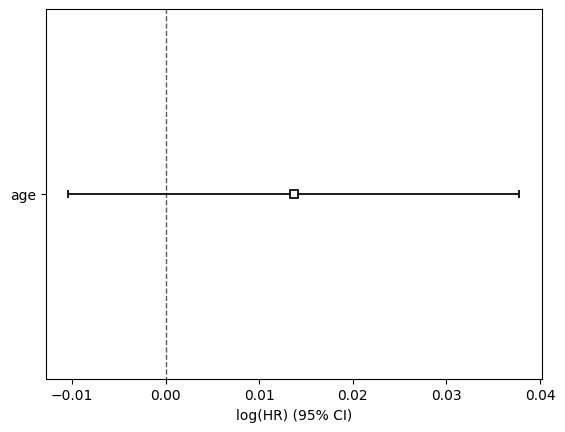

In [32]:
# Use just 'Age Date Dx Liver Cancer' for refit
age_col = 'Age Date Dx Liver Cancer'
X_age = X_nonzero_filtered[[age_col]]

# Prepare data as required by lifelines
df_lf = pd.DataFrame({
    'age': X_age[age_col].values,
    'duration': y['duration'],
    'event': y['event'].astype(int)
})

cph = CoxPHFitter()
cph.fit(df_lf, duration_col='duration', event_col='event')
cph.print_summary()  # Shows HR, 95% CI, and p-value

# You can also plot:
cph.plot()

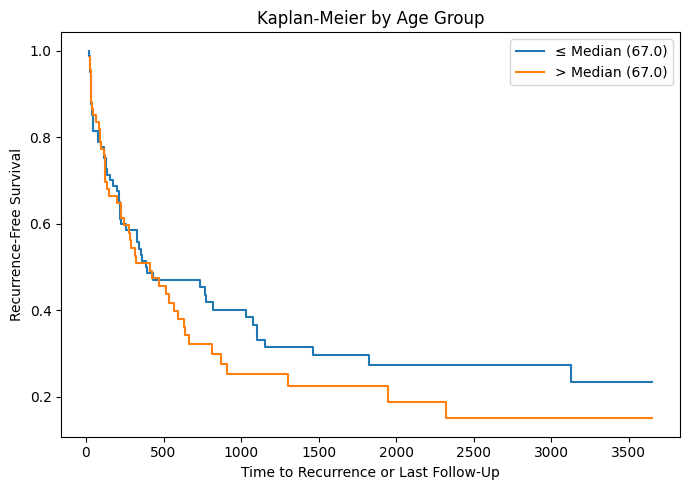

In [33]:
# Split age at median for visualization
median_age = X_age[age_col].median()
age_group = X_age[age_col] > median_age

# Plot KM curves
plt.figure(figsize=(7,5))
for group, label in zip([False, True], [f'≤ Median ({median_age:.1f})', f'> Median ({median_age:.1f})']):
    mask = (age_group == group)
    time, survival_prob = kaplan_meier_estimator(
        y[mask]['event'], y[mask]['duration']
    )
    plt.step(time, survival_prob, label=label)
plt.xlabel('Time to Recurrence or Last Follow-Up')
plt.ylabel('Recurrence-Free Survival')
plt.title('Kaplan-Meier by Age Group')
plt.legend()
plt.tight_layout()
plt.show()

Index(['95% lower-bound', '95% upper-bound'], dtype='object')


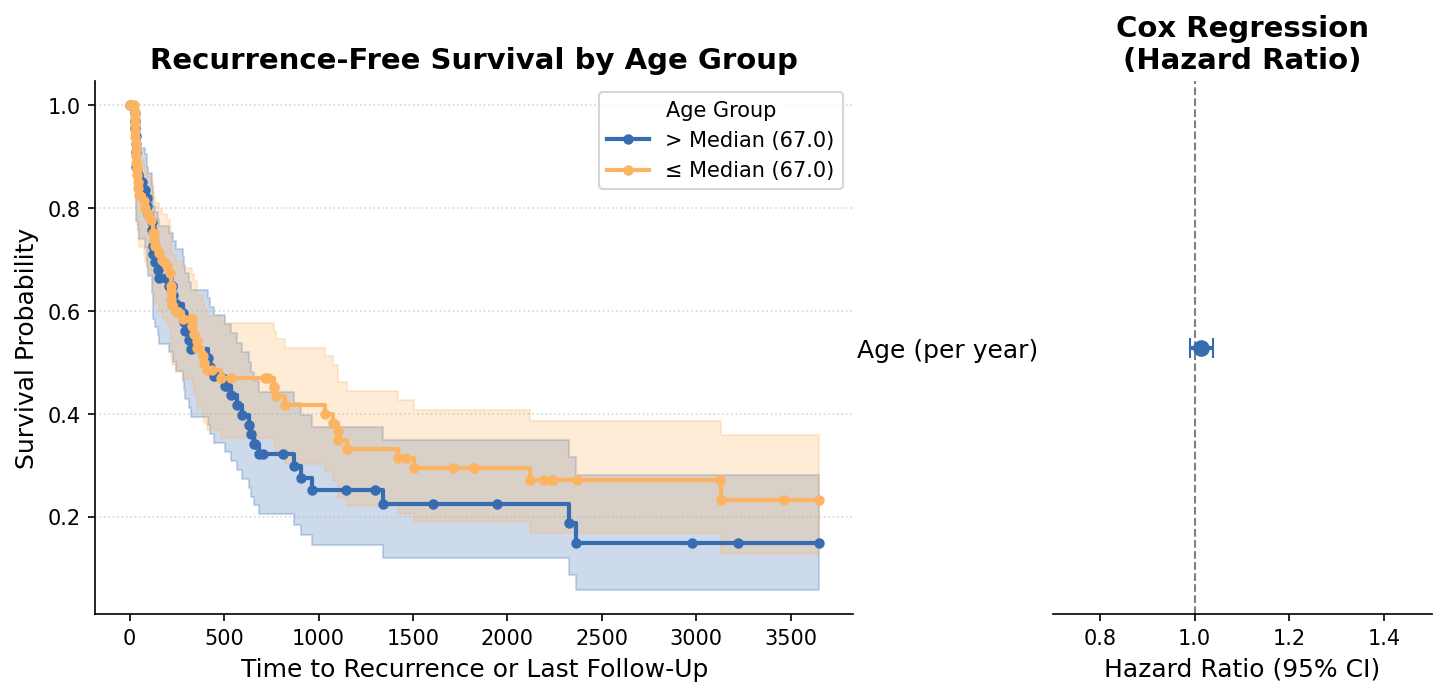

<Figure size 640x480 with 0 Axes>

In [34]:
# Prepare data for lifelines
df_lf = pd.DataFrame({
    'age': X_age[age_col].values,
    'duration': y['duration'],
    'event': y['event'].astype(int)
})

# Stratify by age (median split)
median_age = df_lf['age'].median()
df_lf['age_group'] = np.where(df_lf['age'] > median_age, f'> Median ({median_age:.1f})', f'≤ Median ({median_age:.1f})')

# Fit Cox model
cph = CoxPHFitter()
cph.fit(df_lf[['age', 'duration', 'event']], duration_col='duration', event_col='event')

# Fit KM curves
kmf = KaplanMeierFitter()

fig, axes = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [2, 1]}, dpi=150)

# --- Left: KM Curves ---
ax_km = axes[0]
colors = ['#386cb0', '#fdb462']  # blue and orange for colorblind friendliness

for i, (group, grp_df) in enumerate(df_lf.groupby('age_group')):
    kmf.fit(grp_df['duration'], grp_df['event'], label=group)
    kmf.plot(ax=ax_km, ci_show=True, color=colors[i], lw=2, marker='o', markersize=4)

ax_km.set_title('Recurrence-Free Survival by Age Group', fontsize=14, weight='bold')
ax_km.set_xlabel('Time to Recurrence or Last Follow-Up', fontsize=12)
ax_km.set_ylabel('Survival Probability', fontsize=12)
ax_km.legend(title="Age Group")
ax_km.grid(axis='y', linestyle=':', alpha=0.5)
ax_km.spines['top'].set_visible(False)
ax_km.spines['right'].set_visible(False)

# --- Right: Forest Plot ---
ax_forest = axes[1]

# After fitting model and printing columns:
print(cph.confidence_intervals_.columns)  # Debugging, see actual column names

hr = np.exp(cph.params_['age'])
ci_low = np.exp(cph.confidence_intervals_.iloc[0, 0])
ci_high = np.exp(cph.confidence_intervals_.iloc[0, 1])

# Now your plotting code follows as before


ax_forest.errorbar(hr, 0, xerr=[[hr - ci_low], [ci_high - hr]],
                   fmt='o', color='#386cb0', ecolor='#386cb0', capsize=5, lw=2, markersize=7)
ax_forest.axvline(1, color='grey', linestyle='--', lw=1)
ax_forest.set_yticks([0])
ax_forest.set_yticklabels(['Age (per year)'], fontsize=12)
ax_forest.set_xlabel('Hazard Ratio (95% CI)', fontsize=12)
ax_forest.set_xlim(left=0.7, right=max(ci_high * 1.1, 1.5))
ax_forest.set_title('Cox Regression\n(Hazard Ratio)', fontsize=14, weight='bold')
ax_forest.spines['top'].set_visible(False)
ax_forest.spines['right'].set_visible(False)
ax_forest.spines['left'].set_visible(False)
ax_forest.yaxis.set_ticks_position('none')

# Remove y grid, tidy layout
ax_forest.grid(False)
plt.tight_layout(pad=2)
fig.subplots_adjust(wspace=0.35)
plt.show()
figpath = "Secondary_Tumor_Recurrence.png"
plt.savefig(figpath, dpi=600, bbox_inches='tight')
plt.savefig("Secondary_Tumor_Recurrence.png", dpi=600, bbox_inches='tight')
!cp Secondary_Tumor_Recurrence.png "/content/drive/My Drive/Tommy Rads/"

In [35]:
# Load the data
df = pd.read_csv('/content/drive/MyDrive/Tommy Rads/Secondary_Recurrence_Treatment.csv', index_col=False, encoding='latin1')

numeric_cols = df.select_dtypes(include=np.number).columns

# Apply the mask to only the numeric columns
df[numeric_cols] = df[numeric_cols].mask(df[numeric_cols] < 0)

print(df)

# 1. 'Recurrence EHD' (binary 1/0, ensure numeric)
df['Recurrence EHD'] = pd.to_numeric(df['Recurrence EHD'], errors='coerce')

# 2. 'Site of EHD' (multi-category, need to extract top 4 sites + 'Other' for one-hot)
# Normalize text and split
site_lists = df['Site of EHD'].fillna('').str.lower().str.replace(r'[^a-z,\s]', '', regex=True).str.split(',')

# Flatten and count frequencies
from collections import Counter
all_sites = [site.strip() for sites in site_lists for site in sites if site.strip()]
site_counts = Counter(all_sites)
top4 = [s for s, _ in site_counts.most_common(4)]

# One-hot encode top 4 and 'Other'
for site in top4:
    df[f'EHD_{site.title()}'] = site_lists.apply(lambda x: int(site in [s.strip() for s in x]))
df['EHD_Other'] = site_lists.apply(lambda x: int(any(s.strip() not in top4 and s.strip() != '' for s in x)))

# 3. 'Treatment recurrence' (integer mapping, then one-hot)
treat_map = {0:'Ablation', 1:'TACE', 2:'TARE', 3:'EBRT', 4:'Systemic Therapy', 5:'Resection', 6:'Transplant', 7:'Combined/Other', 8:'None'}
df['Treatment recurrence'] = pd.to_numeric(df['Treatment recurrence'], errors='coerce')
df['Treatment recurrence'] = df['Treatment recurrence'].map(treat_map)
df = pd.get_dummies(df, columns=['Treatment recurrence'], prefix='Tx', dummy_na=False)

# 4. Scalar columns (ensure numeric)
scalar_cols = ['WBC2', 'Hgb5', 'Plt6', 'Na7', 'Cr8', 'Albumin2', 'Tbili2', 'INR11',
               'CEA13', '# tumors to ablate', 'Longest Diameter Largest lesion', 'Sum Longest Diameters15']
for col in scalar_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 5. 'Unilobar (0), Bilobar (1)17' (binary)
df['Unilobar (0), Bilobar (1)17'] = pd.to_numeric(df['Unilobar (0), Bilobar (1)17'], errors='coerce')

# 6. 'PS20' (scalar; all values are used as-is)
df['PS20'] = pd.to_numeric(df['PS20'], errors='coerce')

# 7. 'Bx Recurrence' (binary, fix '2 (done during research treatments)' → 1)
df['Bx Recurrence'] = df['Bx Recurrence'].replace({'2 (done during research treatments)': 1})
df['Bx Recurrence'] = pd.to_numeric(df['Bx Recurrence'], errors='coerce')

# 8. 'Results follow-up Imaging at target lesion' (categorical: CR, PR, PD, SD; one-hot)
df = pd.get_dummies(df, columns=['Results follow-up Imaging at target lesion'], prefix='Imaging', dummy_na=False)

# 9. 'Progression Local(0-no,1-yes)' (binary)
df['Progression Local(0-no,1-yes)'] = pd.to_numeric(df['Progression Local(0-no,1-yes)'], errors='coerce')

# 10. 'TTP after repeat treatment' (scalar)
df['TTP after repeat treatment'] = pd.to_numeric(df['TTP after repeat treatment'], errors='coerce')

# Show head and summary of missingness
print(df.head())
print("\nMissing values per column:")
print(df.isna().sum())

       Last Name        ID #  First Name         DOB  Sex   Race    Ethnicity  \
0         WOJCIK  8454309220        DEAN   4/18/1966    M  White  NotHispanic   
1         HARDER  8444430482    BENJAMIN   8/22/1957    M  Asian  NotHispanic   
2          SMITH  8446758898       DIANE   6/13/1953    F  White  NotHispanic   
3          LENZA  8447363078      PAMELA   6/28/1956    F  White  NotHispanic   
4          HUMPF  8443337852      JOSEPH    6/9/1963    M  White  NotHispanic   
5      SCHWARZER  8470587692       SOFIA   7/21/1947    F  White  NotHispanic   
6        ETZRODT  1000285439        MARY   7/16/1940    F  White  NotHispanic   
7        DALAIMO  8464446319       JAMES  10/28/1969    M  White  NotHispanic   
8        LABORDE  8448830554       BRIAN   8/18/1962    M  White  NotHispanic   
9           RATH  8452237464  ANTOINETTE    1/9/1959    F  White  NotHispanic   
10        NESCIO  8000310878      JOSEPH    6/9/1952    M  White  NotHispanic   
11        LABBEE  1004585444

In [36]:
# Identify columns for imputation (all scalar/binary)
impute_cols = [
    'Recurrence EHD',
    'WBC2', 'Hgb5', 'Plt6', 'Na7', 'Cr8', 'Albumin2', 'Tbili2', 'INR11',
    'CEA13', '# tumors to ablate', 'Longest Diameter Largest lesion', 'Sum Longest Diameters15',
    'Unilobar (0), Bilobar (1)17', 'PS20', 'Bx Recurrence', 'Progression Local(0-no,1-yes)',
    'TTP after repeat treatment'
    # plus EHD_* columns (one-hot), if you want to impute those as well:
] + [col for col in df.columns if col.startswith('EHD_')]

# Create a working DataFrame for imputation
impute_df = df[impute_cols]

# Run MICE imputation
imputer = IterativeImputer(random_state=42, max_iter=20)
imputed_array = imputer.fit_transform(impute_df)
imputed_df = pd.DataFrame(imputed_array, columns=impute_df.columns, index=impute_df.index)

# For true binary columns, round and cast to int
binary_cols = [
    'Recurrence EHD', 'Unilobar (0), Bilobar (1)17', 'Bx Recurrence', 'Progression Local(0-no,1-yes)'
] + [col for col in df.columns if col.startswith('EHD_')]
for col in binary_cols:
    imputed_df[col] = imputed_df[col].round().astype(int)

# Combine back with the categorical dummies (imaging, treatment, etc.)
non_impute_cols = [col for col in df.columns if col not in impute_cols]
final_df = pd.concat([imputed_df, df[non_impute_cols]], axis=1)

# Show results
print(final_df.head())
print("\nRemaining NaNs after imputation:", final_df.isna().sum().sum())

   Recurrence EHD  WBC2  Hgb5   Plt6    Na7   Cr8  Albumin2  Tbili2  INR11  \
0               1  10.1  15.9  229.0  138.0  1.22       4.1     0.6    1.0   
1               0   6.1  14.5  160.0  134.0  0.77       4.1     0.5    0.9   
2               0   9.6  10.6  256.0  138.0  0.97       3.5     0.3    0.9   
3               0   6.1  13.7  294.0  139.0  0.71       3.8     0.5    0.9   
4               1   9.9  14.2  417.0  137.0  0.85       4.3     0.5    1.0   

       CEA13  # tumors to ablate  Longest Diameter Largest lesion  \
0  47.409835                20.0                             12.0   
1   3.100000                 1.0                             10.0   
2  47.445618                 1.0                             35.0   
3  47.578738                 1.0                             16.0   
4  47.738204                 3.0                             43.0   

   Sum Longest Diameters15  Unilobar (0), Bilobar (1)17  PS20  Bx Recurrence  \
0                     22.0          

In [37]:
# Only these columns will be used downstream
main_predictors = (
    ['Recurrence EHD'] +
    ['EHD_' + s.title() for s in top4] +
    ['EHD_Other'] +
    [col for col in df.columns if col.startswith('Tx_')] +
    [
        'WBC2', 'Hgb5', 'Plt6', 'Na7', 'Cr8', 'Albumin2', 'Tbili2', 'INR11',
        'CEA13', '# tumors to ablate', 'Longest Diameter Largest lesion', 'Sum Longest Diameters15',
        'Unilobar (0), Bilobar (1)17', 'PS20', 'Bx Recurrence',
        'Progression Local(0-no,1-yes)'
    ]
)

X_model = final_df[main_predictors]

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

predictors = [col for col in final_df.columns if col not in [
    # outcome columns, known dummies
    'Results follow-up Imaging at target lesion_CR',
    'Results follow-up Imaging at target lesion_PR',
    'Results follow-up Imaging at target lesion_PD',
    'Results follow-up Imaging at target lesion_SD',
    'TTP after repeat treatment',
    'Progression Local(0-no,1-yes)'
]]

# Tx_Ablation will be the reference, will be dropped to avoid perfect collinearity among one-hot encoded variables
predictors = [col for col in X_model.columns if not col == 'Tx_Ablation']

X_vif = X_model[predictors].dropna().astype(float)
vif_data = pd.DataFrame({
    'feature': X_vif.columns,
    'VIF': [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
print(vif_data.sort_values('VIF', ascending=False))


                            feature         VIF
18                         Albumin2  807.981425
16                              Na7  634.056482
14                             Hgb5  434.204465
20                            INR11  190.195615
13                             WBC2   95.735981
17                              Cr8   29.738480
15                             Plt6   29.493889
23  Longest Diameter Largest lesion   28.276289
19                           Tbili2   27.225253
24          Sum Longest Diameters15   22.040650
21                            CEA13   17.592405
28    Progression Local(0-no,1-yes)   14.490698
0                    Recurrence EHD   10.198416
22               # tumors to ablate    7.004971
26                             PS20    5.756708
10              Tx_Systemic Therapy    5.593644
25      Unilobar (0), Bilobar (1)17    5.334839
27                    Bx Recurrence    4.329676
1                          EHD_Lung    3.615924
5                         EHD_Other    3

In [39]:
# Set your VIF threshold
vif_threshold = 650

# Identify columns above the threshold
high_vif_cols = vif_data[vif_data['VIF'] > vif_threshold]['feature'].tolist()
print("Dropping due to high VIF:", high_vif_cols)

# Remove these columns from your predictors
predictors = [col for col in predictors if col not in high_vif_cols]

# Subset your model data to these new predictors
X_model_reduced = X_model[predictors]


Dropping due to high VIF: ['Albumin2']


In [40]:
X_vif = X_model_reduced.dropna().astype(float)
vif_data_new = pd.DataFrame({
    'feature': X_vif.columns,
    'VIF': [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
print("\nNew VIF table (after dropping high-VIF columns):")
print(vif_data_new.sort_values('VIF', ascending=False))



New VIF table (after dropping high-VIF columns):
                            feature         VIF
16                              Na7  455.777671
14                             Hgb5  190.621633
19                            INR11  181.656387
13                             WBC2   74.139384
15                             Plt6   28.617165
22  Longest Diameter Largest lesion   28.026225
18                           Tbili2   26.559498
23          Sum Longest Diameters15   21.828552
27    Progression Local(0-no,1-yes)   13.473065
20                            CEA13   12.722574
0                    Recurrence EHD   10.189434
17                              Cr8    7.574859
21               # tumors to ablate    6.899727
10              Tx_Systemic Therapy    5.568263
24      Unilobar (0), Bilobar (1)17    5.321487
25                             PS20    4.714767
26                    Bx Recurrence    3.960753
1                          EHD_Lung    3.586394
5                         EHD_Other   

In [41]:
treatment_cols = [col for col in X_model_reduced.columns if col.startswith('Tx_')]
ps_covariates = [col for col in X_model_reduced.columns if not col.startswith('Tx_')]

from sklearn.linear_model import LogisticRegression

for treat_col in treatment_cols:
    # Binary outcome: this treatment vs. all others
    y_treat = final_df[treat_col]
    # Skip if all zeros or all ones (shouldn't happen, but just in case)
    if y_treat.nunique() < 2:
        print(f"Skipping {treat_col}: only one class present.")
        continue

    ps_model = LogisticRegression(max_iter=1000)
    ps_model.fit(final_df[ps_covariates], y_treat)
    final_df[f'pscore_{treat_col}'] = ps_model.predict_proba(final_df[ps_covariates])[:,1]
    print(f"Calculated propensity scores for {treat_col}")


Calculated propensity scores for Tx_Combined/Other
Calculated propensity scores for Tx_EBRT


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Calculated propensity scores for Tx_None
Calculated propensity scores for Tx_Resection


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Calculated propensity scores for Tx_Systemic Therapy
Calculated propensity scores for Tx_TACE
Calculated propensity scores for Tx_TARE


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [42]:
for treat_col in treatment_cols:
    pscore_col = f'pscore_{treat_col}'
    treat = final_df[treat_col]
    pscore = final_df[pscore_col]
    # IPTW: for those who received the treatment, weight = 1/pscore
    # for others, weight = 1/(1-pscore)
    final_df[f'iptw_{treat_col}'] = np.where(treat == 1, 1/pscore, 1/(1-pscore))


In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

# Define your multinomial outcome (replace with your actual column)
# Here, assume imaging outcome is in a single column, e.g., 'ImagingOutcome'
# (If you still have one-hot columns, reconstruct single outcome with .idxmax)
if 'Results follow-up Imaging at target lesion' in final_df.columns:
    y_multi = final_df['Results follow-up Imaging at target lesion']
else:
    # Reconstruct from one-hot columns if needed
    imaging_cols = [col for col in final_df.columns if col.startswith('Imaging_')]
    y_multi = final_df[imaging_cols].idxmax(axis=1).str.replace('Imaging_', '')

# Loop over all treatments for weighted multinomial regression
for treat_col in treatment_cols:
    iptw_col = f'iptw_{treat_col}'
    print(f"\nMultinomial model, weighting by IPTW for {treat_col}:")
    sample_weight = final_df[iptw_col]
    X_multi = X_model_reduced  # Use your cleaned predictors
    y_enc = LabelEncoder().fit_transform(y_multi)

    # Use multinomial logistic regression with sample weights
    multi_logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
    multi_logreg.fit(X_multi, y_enc, sample_weight=sample_weight)
    # Print coefficients and odds ratios for review
    print("Classes:", multi_logreg.classes_)
    print("Odds Ratios (exp(coef)):\n", np.exp(multi_logreg.coef_))



Multinomial model, weighting by IPTW for Tx_Combined/Other:


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'mul

Classes: [0 1 2 3]
Odds Ratios (exp(coef)):
 [[1.09590181 0.63237083 1.14785589 0.3490909  0.81885754 0.75909614
  0.43999483 1.5484974  2.86344821 1.80242691 0.19393573 0.4400476
  0.66805277 1.01697748 0.96899563 0.99740823 1.01781143 0.89856726
  0.98033753 1.09951233 1.01141195 1.27073941 1.02262135 0.99074744
  1.2416762  0.90438681 0.88352583 0.48791665]
 [1.06732065 0.65366173 1.0268465  1.75923667 1.10245108 3.34287113
  0.78631355 0.97072553 0.66730457 0.95499554 1.58102757 1.30418223
  0.89488585 1.6162193  0.62640162 0.99679688 1.01828257 1.02399396
  0.70250685 0.8799547  0.98942076 1.3241905  0.99820023 0.99125948
  0.78669225 1.07234158 1.53939864 2.06956359]
 [1.41164783 2.14847896 1.67907829 2.30146484 1.31974376 0.51678302
  3.65476201 0.68963525 0.63969714 0.62970759 2.08794163 1.07572979
  1.18406193 0.72239239 1.35697247 1.00070211 0.99139987 1.04129166
  1.43393579 1.04399081 1.01590971 0.57899801 0.95495825 1.02298505
  0.87302983 0.59814025 0.8565634  0.63104299]

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classes: [0 1 2 3]
Odds Ratios (exp(coef)):
 [[1.36794494 0.88041555 1.0461525  0.32756533 0.82575658 0.63882546
  0.73913439 2.41323954 2.77756382 1.76948479 0.18218936 0.35789973
  0.62213112 0.99728228 0.98991617 0.99887822 1.01528398 0.92488165
  1.11009882 1.18122477 1.00611923 1.16351232 1.00870854 0.99702217
  1.12193924 0.89296199 0.7659987  0.56270113]
 [1.09224146 0.616243   1.03322647 1.78437435 1.12081654 3.43380641
  0.88345235 0.86279278 0.67553257 0.94508666 1.59395118 1.29298709
  0.88569584 1.60499562 0.6556266  0.99706123 1.01396743 1.01824744
  0.69712309 0.88113352 0.99366786 1.21218173 0.99264983 0.99561293
  0.75587399 1.01259047 1.6069511  2.10075534]
 [1.11656742 1.62325548 1.88312772 2.45218516 1.28978765 0.61184812
  1.61582876 0.57456482 0.65457589 0.65467061 2.2207687  1.31893057
  1.29956173 0.76867389 1.25416288 0.99892126 0.99704151 1.0305032
  1.24161613 0.96210059 1.01557686 0.68637915 0.97149321 1.01672052
  0.98948264 0.66826545 0.94762797 0.51079069]

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classes: [0 1 2 3]
Odds Ratios (exp(coef)):
 [[1.15162015 0.7436923  1.1804569  0.33869553 0.82202138 0.6498145
  0.84918936 1.26060696 5.6950813  1.67782213 0.15670119 0.35808754
  0.60129934 0.97946633 1.01175522 0.99848304 1.01344697 0.92297895
  1.07847664 1.1583579  1.01157647 1.22734473 1.02188062 0.98993074
  1.14630002 0.91986847 0.74474623 0.51297828]
 [1.10706357 0.656564   0.94025724 1.82535472 1.07990813 3.68242163
  0.88497056 0.96090461 0.53696343 0.94849211 1.661813   1.32792721
  0.89849886 1.66176848 0.61169613 0.99669425 1.02057016 1.01457359
  0.69127441 0.87034212 0.98910841 1.23805397 1.00146812 0.98892005
  0.7568715  1.02650336 1.66858158 2.15440513]
 [1.26412703 1.65403424 1.93320723 2.35101743 1.35437489 0.57205945
  1.4187877  0.87048198 0.48713157 0.68753435 2.38311973 1.27915697
  1.2900143  0.77090654 1.29307267 0.99911292 0.99327473 1.03438025
  1.30099068 0.99113604 1.01563841 0.6470734  0.96355836 1.02231075
  0.97153096 0.65740866 0.94272734 0.53787721]

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classes: [0 1 2 3]
Odds Ratios (exp(coef)):
 [[1.06934663 0.74508898 1.05174002 0.34484895 0.8028475  0.64494791
  0.77978531 1.2530273  2.67021208 3.02478949 0.17497529 0.3896516
  0.59819899 0.99595318 0.99773534 0.99823671 1.01574381 0.91243375
  1.0550065  1.16271082 1.01080546 1.23056486 1.01990907 0.99038961
  1.18620418 0.82480469 0.70769285 0.53858443]
 [1.11897371 0.65825196 1.00195812 1.79198919 1.09759832 3.36951763
  0.87679963 0.95941784 0.67109065 0.82949144 1.59772737 1.28738922
  0.8906812  1.66794374 0.62382152 0.99663954 1.01692639 1.02152156
  0.70864466 0.88222331 0.99273729 1.25284624 0.99599821 0.99261718
  0.76006896 1.01915441 1.65301458 2.13459498]
 [1.28297662 1.66307704 1.95137342 2.3415316  1.35513748 0.61871376
  1.56301018 0.87432983 0.66824414 0.52177697 2.27196471 1.23112346
  1.31662631 0.74236695 1.29904337 0.99991019 0.99494589 1.03623828
  1.29243097 0.97769101 1.01252225 0.64453002 0.96174717 1.02187164
  0.94050799 0.68149811 0.9950017  0.51854754]

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classes: [0 1 2 3]
Odds Ratios (exp(coef)):
 [[1.36746427 0.81091088 1.2623124  0.34693862 0.80850681 0.60816139
  0.83158958 1.28527211 3.67929753 1.68960566 0.12080652 0.3646562
  0.66638656 0.91387203 1.08032581 0.997875   1.01217051 0.87540088
  0.9489438  1.17413532 1.01296983 1.25273703 1.01438615 0.99438619
  1.15878828 0.9309961  0.79465653 0.52237492]
 [1.50048868 0.64909653 0.94569361 2.54058539 1.0934924  4.40203584
  0.9080887  0.95711873 0.6421272  0.96042166 1.69498277 1.19436304
  0.88486559 1.68452832 0.56339865 0.9971469  1.03039662 1.02854597
  0.64385473 0.8597869  0.9789554  1.31450353 0.98057388 0.99074812
  0.71527354 1.02177463 1.56453127 2.1944437 ]
 [1.34733544 1.74094189 2.41496847 2.07332828 1.42696827 0.56356419
  1.41307296 0.86429167 0.57247564 0.69676733 2.11420454 1.33978444
  1.31132815 0.794588   1.20193144 0.998549   1.00325904 1.04190377
  1.5854398  0.99676503 1.01062348 0.59921635 0.96608466 1.01947668
  1.00600294 0.65279934 0.9843354  0.40495811]

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classes: [0 1 2 3]
Odds Ratios (exp(coef)):
 [[1.08129075 0.58546231 1.17569699 0.3838396  0.80190528 0.64525509
  0.90321565 1.32204541 3.33987065 1.6095924  0.25932531 0.21429378
  0.71421434 0.9505995  1.0362004  0.99865093 1.01323743 0.88821489
  1.02083256 1.1321118  1.01340892 1.13519983 1.01353629 0.99472405
  1.2727978  0.87598931 0.87102908 0.51129854]
 [1.02067652 0.72672311 1.53920887 1.73582257 0.9355765  5.46720303
  0.85770616 0.94326563 0.66230778 0.94231172 1.58876259 1.42496822
  0.88522441 1.76907047 0.54055115 0.99725853 1.03157688 1.02570112
  0.70148789 0.89413913 0.986291   1.22476881 0.98339628 0.9920212
  0.74823166 0.76065859 1.40740186 2.25723038]
 [1.23456719 0.99208825 1.71857516 3.5558676  2.44060033 0.5509948
  1.484313   0.93824812 0.60557899 0.73320871 2.1184644  1.05523655
  1.17911727 0.68214808 1.44272588 1.00062329 0.98620386 1.05012715
  1.36658525 0.99899583 1.00660301 0.70856856 0.97815385 1.01529756
  0.98008606 0.96127068 1.03314044 0.49582758]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [47]:
from sksurv.util import Surv

# Prepare survival data
final_df['duration'] = np.where(
    final_df['Progression Local(0-no,1-yes)'] == 1,
    final_df['TTP after repeat treatment'],
    final_df['Days between follow up and first ablation']
)
final_df = final_df.dropna(subset=['duration', 'Progression Local(0-no,1-yes)'])

y_surv = Surv.from_arrays(
    event=final_df['Progression Local(0-no,1-yes)'].astype(bool),
    time=final_df['duration']
)

df_life = final_df[['duration', 'Progression Local(0-no,1-yes)'] + predictors].copy()

# --- Helper Functions ---
def drop_object_columns(df):
    object_cols = df.select_dtypes(include=['object']).columns.tolist()
    if object_cols:
        print("Dropping non-numeric (object) columns:", object_cols)
        df = df.drop(columns=object_cols)
    return df

def drop_low_variance(df, threshold=1e-3):
    low_var_cols = []
    for col in df.select_dtypes(include=[np.number]).columns:
        if col not in ['duration', 'Progression Local(0-no,1-yes)', 'weight']:
            try:
                if df[col].var() < threshold:
                    low_var_cols.append(col)
            except Exception as e:
                print(f"Could not calculate variance for {col}: {e}")
    if low_var_cols:
        print("Dropping near-zero variance columns:", low_var_cols)
        df = df.drop(columns=low_var_cols)
    return df

def drop_sparse_columns(df, min_nonzero=4):
    problem_cols = []
    for col in df.columns:
        if col in ['duration', 'Progression Local(0-no,1-yes)', 'weight']:
            continue
        if not np.issubdtype(df[col].dtype, np.number):
            continue
        pos_event = ((df[col] > 0) & (df['Progression Local(0-no,1-yes)'] == 1)).sum()
        pos_cens = ((df[col] > 0) & (df['Progression Local(0-no,1-yes)'] == 0)).sum()
        if pos_event < min_nonzero or pos_cens < min_nonzero:
            problem_cols.append(col)
    if problem_cols:
        print("Dropping rare/separating dummies:", problem_cols)
        df = df.drop(columns=problem_cols)
    return df

# --- Main Loop ---
all_results = []
all_cph_summaries = {}

for treat_col in treatment_cols:
    iptw_col = f'iptw_{treat_col}'
    print(f"\nCox model, weighting by IPTW for {treat_col}:")
    df_life['weight'] = final_df[iptw_col]
    cph_df = df_life.copy()

    cph_df = cph_df.loc[:, ~cph_df.columns.duplicated()]
    if cph_df.columns.duplicated().any():
        print("Warning: duplicate columns found and removed:", cph_df.columns[cph_df.columns.duplicated()].tolist())

    # Clean the data
    cph_df = drop_object_columns(cph_df)
    cph_df = drop_low_variance(cph_df)
    cph_df = drop_sparse_columns(cph_df)

    # Fit Cox model once
    cph = CoxPHFitter()
    try:
        cph.fit(
            cph_df,
            duration_col='duration',
            event_col='Progression Local(0-no,1-yes)',
            weights_col='weight',
            robust=True
        )

        print(cph.summary[['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p']])

        df_summary = cph.summary.reset_index()
        df_summary['treatment'] = treat_col
        all_results.append(df_summary)

        all_cph_summaries[treat_col] = cph.summary.copy()

    except Exception as e:
        print("Cox model failed for", treat_col, ":", e)


Cox model, weighting by IPTW for Tx_Combined/Other:
Dropping rare/separating dummies: ['EHD_Lymph', 'EHD_Bone', 'EHD_Brain', 'EHD_Other', 'Unilobar (0), Bilobar (1)17', 'Bx Recurrence']


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column Tx_EBRT have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['Progression Local(0-no,1-yes)'].astype(bool)
>>> print(df.loc[events, 'Tx_EBRT'].var())
>>> print(df.loc[~events, 'Tx_EBRT'].var())

A very low variance means that the column Tx_EBRT completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-con

                                   exp(coef)  exp(coef) lower 95%  \
covariate                                                           
Recurrence EHD                      1.145084         4.121891e-02   
EHD_Lung                            0.128235         2.832542e-05   
Tx_Combined/Other                   1.423349         1.671721e-04   
Tx_EBRT                            12.250366         1.865292e-06   
Tx_None                          2358.438341         2.058329e-06   
Tx_Resection                        0.375330         3.834762e-03   
Tx_Systemic Therapy                 6.291777         1.717698e-04   
Tx_TACE                             5.291231         1.271337e-04   
Tx_TARE                             6.578574         5.775167e-04   
WBC2                                1.578918         1.149115e-01   
Hgb5                                0.834556         1.527212e-01   
Plt6                                0.996882         9.642353e-01   
Na7                               

/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column Tx_EBRT have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['Progression Local(0-no,1-yes)'].astype(bool)
>>> print(df.loc[events, 'Tx_EBRT'].var())
>>> print(df.loc[~events, 'Tx_EBRT'].var())

A very low variance means that the column Tx_EBRT completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-con

                                 exp(coef)  exp(coef) lower 95%  \
covariate                                                         
Recurrence EHD                    0.428789         8.190101e-08   
EHD_Lung                          0.072763         5.046959e-07   
Tx_Combined/Other                 0.017888         3.309368e-29   
Tx_EBRT                           9.076839         7.222021e-09   
Tx_None                          65.340769         5.832619e-03   
Tx_Resection                      0.499172         8.495270e-09   
Tx_Systemic Therapy               4.242854         1.872368e-07   
Tx_TACE                          31.688744         1.183119e-10   
Tx_TARE                           0.091589         5.521309e-13   
WBC2                              3.482826         7.661438e-01   
Hgb5                              0.415594         7.629605e-05   
Plt6                              0.982292         8.310118e-01   
Na7                               1.150168         4.859842e-0

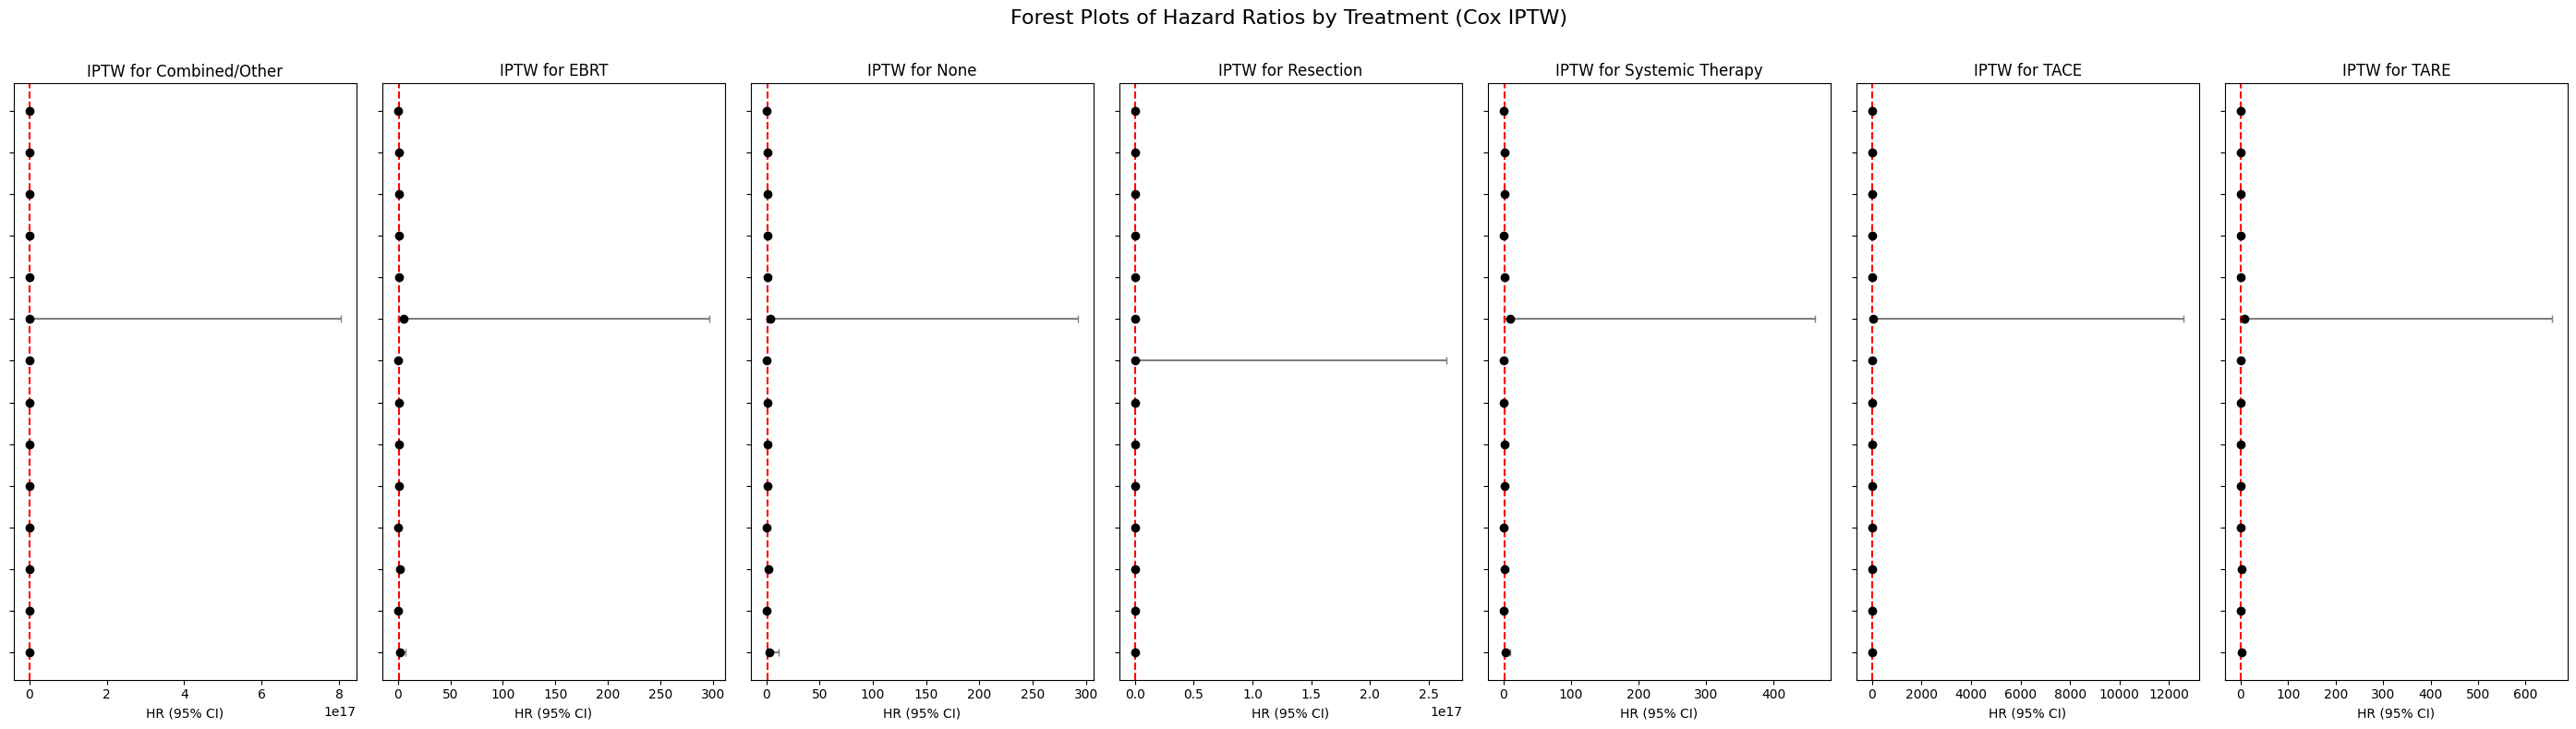

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Only show real predictors (drop treatment dummies from y-axis)
predictor_mask = lambda df: ~df.index.str.startswith('Tx_')
num_panels = len(all_cph_summaries)
panel_names = list(all_cph_summaries.keys())

fig, axes = plt.subplots(1, num_panels, figsize=(4*num_panels, 8), sharey=True)

if num_panels == 1:
    axes = [axes]  # so the code works for single treatment too

for i, treat_col in enumerate(panel_names):
    s = all_cph_summaries[treat_col]
    s = s.loc[predictor_mask(s)]
    hr = s['exp(coef)']
    err_lower = hr - s['exp(coef) lower 95%']
    err_upper = s['exp(coef) upper 95%'] - hr
    y_pos = np.arange(len(s))

    axes[i].errorbar(hr, y_pos, xerr=[err_lower, err_upper], fmt='o', color='black', ecolor='gray', capsize=3)
    axes[i].axvline(1, color='red', linestyle='--')
    axes[i].set_yticks(y_pos)
    axes[i].set_yticklabels(s.index if i == 0 else ['']*len(s))
    axes[i].set_xlabel('HR (95% CI)')
    axes[i].set_title(treat_col.replace("Tx_", "IPTW for "))

plt.suptitle("Forest Plots of Hazard Ratios by Treatment (Cox IPTW)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


/tmp/ipython-input-53-1172766435.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if not np.isnan(pvals[j]) and pvals[j] < 0.05:


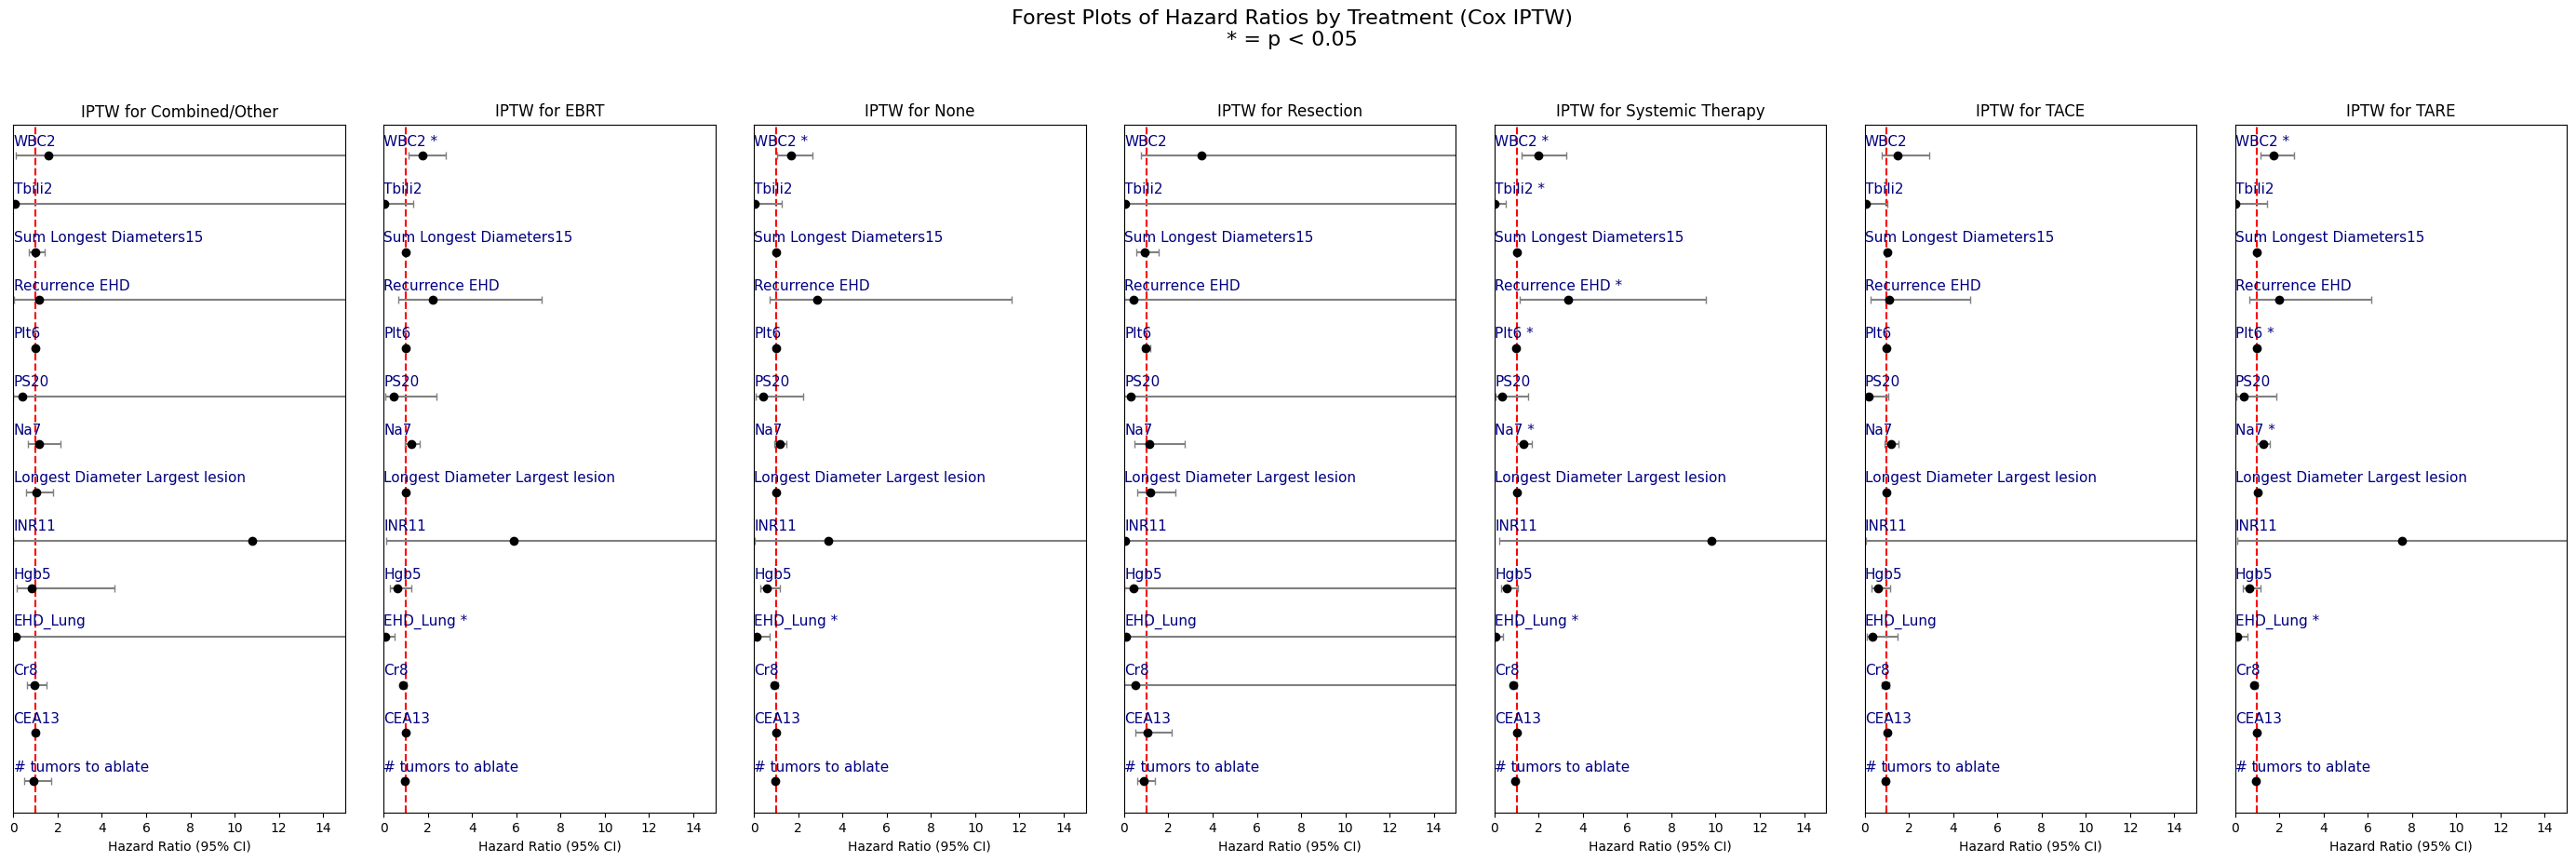

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare panel order and sort variables alphabetically
panel_names = list(all_cph_summaries.keys())
# Find all predictor names across models, dropping treatment dummies
all_vars = set()
for summary in all_cph_summaries.values():
    all_vars |= set([ix for ix in summary.index if not ix.startswith('Tx_')])
all_vars = sorted(all_vars)  # Alphabetical order

fig, axes = plt.subplots(1, len(panel_names), figsize=(4*len(panel_names), 1+len(all_vars)*0.6), sharey=True)

if len(panel_names) == 1:
    axes = [axes]

for i, treat_col in enumerate(panel_names):
    s = all_cph_summaries[treat_col]
    # Restrict and reindex to all_vars in order
    s = s.loc[s.index.isin(all_vars)].reindex(all_vars)
    hr = s['exp(coef)']
    err_lower = hr - s['exp(coef) lower 95%']
    err_upper = s['exp(coef) upper 95%'] - hr
    pvals = s['p']

    y_pos = np.arange(len(all_vars))

    axes[i].errorbar(hr, y_pos, xerr=[err_lower, err_upper], fmt='o', color='black', ecolor='gray', capsize=3, zorder=1)
    axes[i].axvline(1, color='red', linestyle='--', zorder=0)
    axes[i].set_xlabel('Hazard Ratio (95% CI)')
    axes[i].set_title(treat_col.replace("Tx_", "IPTW for "))
    axes[i].set_xlim(left=0, right=min(axes[i].get_xlim()[1], 15))

    # Inline labels and asterisks for significance
    for j, var in enumerate(all_vars):
        label = var
        if not np.isnan(pvals[j]) and pvals[j] < 0.05:
            label += " *"
        axes[i].text(axes[i].get_xlim()[0] + 0.01, y_pos[j] + 0.15, label,
                     va='bottom', ha='left', fontsize=11, color='navy', zorder=2)
    axes[i].set_yticks([])  # Hide y-tick labels for clean appearance

plt.suptitle("Forest Plots of Hazard Ratios by Treatment (Cox IPTW)\n* = p < 0.05", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [49]:
import numpy as np
import pandas as pd

# Concatenate all results
results_df = pd.concat(all_results, axis=0)

# Build heatmap data: -log10(p-value)
heatmap_df = results_df.pivot_table(index='covariate', columns='treatment', values='p')
heatmap_logp = -np.log10(heatmap_df)

# Optionally: zero out non-significant effects (e.g., p>0.05)
heatmap_logp_masked = heatmap_logp.where(heatmap_df <= 0.05, other=0)

# Or, to show signed effects (up/down regulation): use np.sign(coef) * -log10(p)
signed_effect = results_df.pivot_table(index='covariate', columns='treatment',
                                       values='exp(coef)').apply(np.log) * -np.log10(heatmap_df)


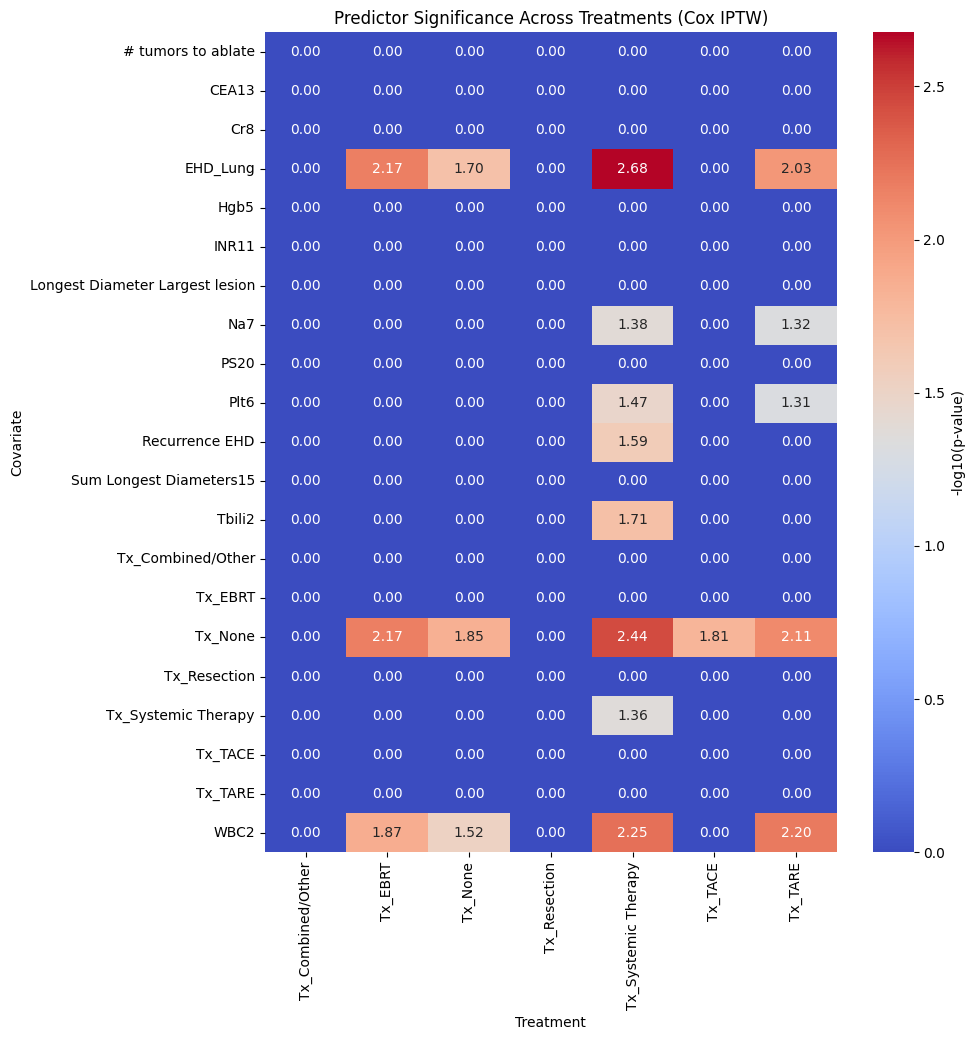

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, max(6, len(heatmap_logp.index) * 0.5)))
sns.heatmap(heatmap_logp_masked, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': '-log10(p-value)'})
plt.title("Predictor Significance Across Treatments (Cox IPTW)")
plt.xlabel("Treatment")
plt.ylabel("Covariate")
plt.tight_layout()
plt.show()


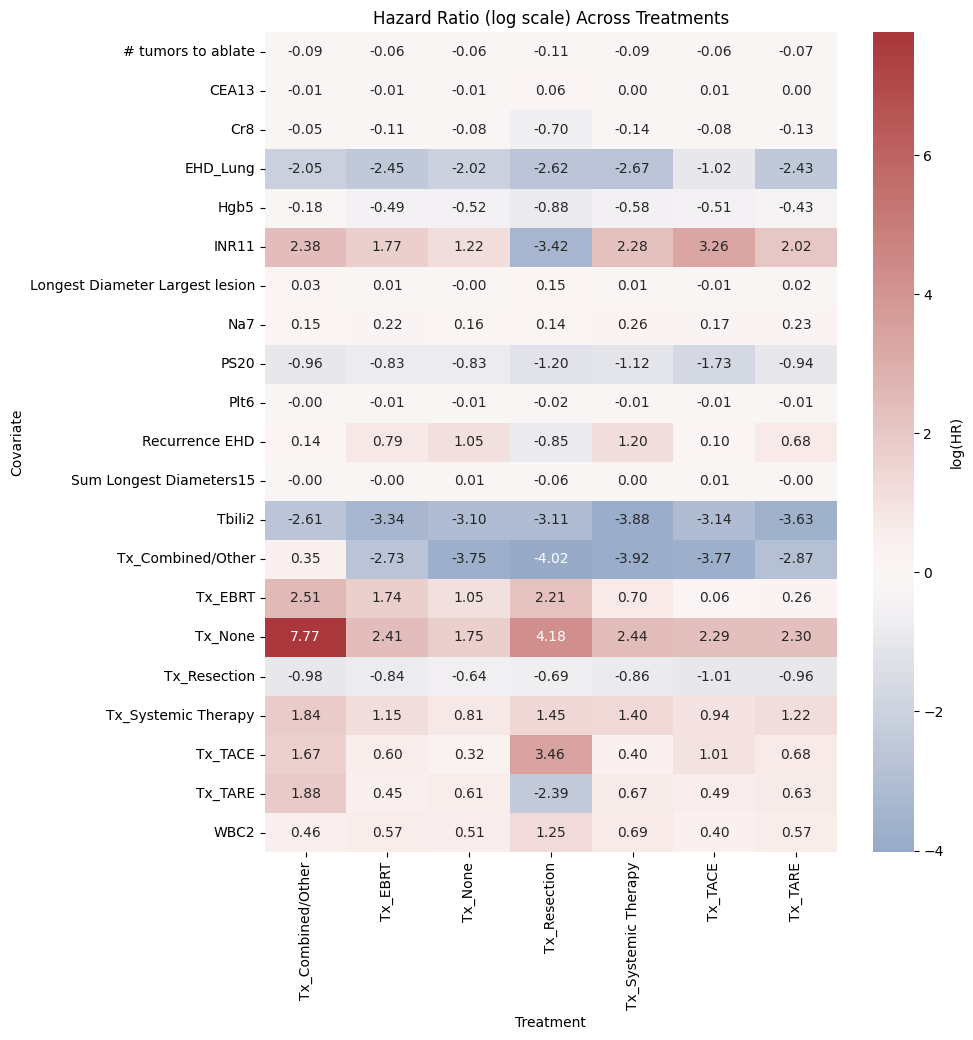

In [51]:
hr_log_df = results_df.pivot_table(index='covariate', columns='treatment', values='coef')
plt.figure(figsize=(10, max(6, len(hr_log_df.index) * 0.5)))
sns.heatmap(hr_log_df, annot=True, fmt=".2f", cmap="vlag", center=0, cbar_kws={'label': 'log(HR)'})
plt.title("Hazard Ratio (log scale) Across Treatments")
plt.xlabel("Treatment")
plt.ylabel("Covariate")
plt.tight_layout()
plt.show()

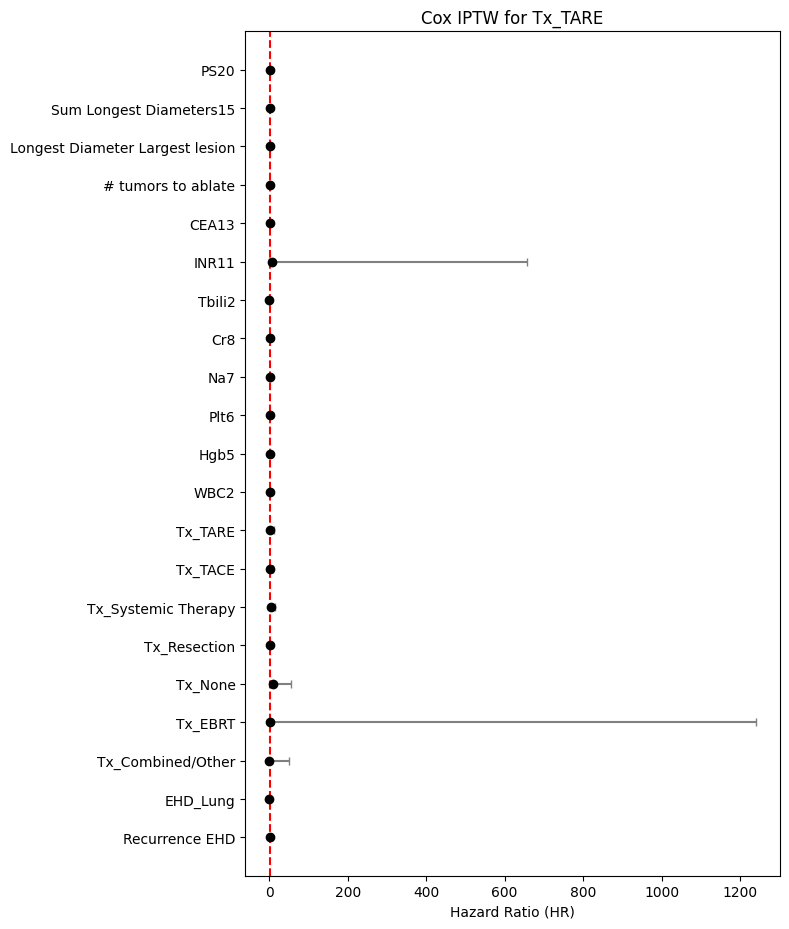

In [52]:
import matplotlib.pyplot as plt

def plot_forest(cph, title=None):
    s = cph.summary
    fig, ax = plt.subplots(figsize=(8, len(s) * 0.4 + 1))
    y_pos = range(len(s))
    hr = s['exp(coef)']
    err_lower = hr - s['exp(coef) lower 95%']
    err_upper = s['exp(coef) upper 95%'] - hr

    ax.errorbar(hr, y_pos, xerr=[err_lower, err_upper], fmt='o', color='black', ecolor='gray', capsize=3)
    ax.axvline(1, color='red', linestyle='--')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(s.index)
    ax.set_xlabel('Hazard Ratio (HR)')
    ax.set_title(title or 'Cox Model (IPTW)')
    plt.tight_layout()
    plt.show()

# Usage, for example after each fit:
plot_forest(cph, title=f'Cox IPTW for {treat_col}')
